In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score

def get_fund_k_history(fund_code: str, pz: int = 1000) -> pd.DataFrame:
    '''
    根据基金代码和要获取的页码抓取基金净值信息

    Parameters
    ----------
    fund_code : 6位基金代码
    page : 页码 1 为最新页数据

    Return
    ------
    DataFrame : 包含基金历史k线数据
    '''
    # 请求头
    EastmoneyFundHeaders = {
        'User-Agent': 'EMProjJijin/6.2.8 (iPhone; iOS 13.6; Scale/2.00)',
        'GTOKEN': '98B423068C1F4DEF9842F82ADF08C5db',
        'clientInfo': 'ttjj-iPhone10,1-iOS-iOS13.6',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Host': 'fundmobapi.eastmoney.com',
        'Referer': 'https://mpservice.com/516939c37bdb4ba2b1138c50cf69a2e1/release/pages/FundHistoryNetWorth',
    }
    # 请求参数
    data = {
        'FCODE': f'{fund_code}',
        'appType': 'ttjj',
        'cToken': '1',
        'deviceid': '1',
        'pageIndex': '1',
        'pageSize': f'{pz}',
        'plat': 'Iphone',
        'product': 'EFund',
        'serverVersion': '6.2.8',
        'version': '6.2.8'
    }
    url = 'https://fundmobapi.eastmoney.com/FundMNewApi/FundMNHisNetList'
    json_response = requests.get(
        url, headers=EastmoneyFundHeaders, data=data).json()
    rows = []
    columns = ['date', 'NAV', 'NAV-Cum', 'change']
    if json_response is None:
        return pd.DataFrame(rows, columns=columns)
    datas = json_response['Datas']
    if len(datas) == 0:
        return pd.DataFrame(rows, columns=columns)
    rows = []
    for stock in datas:
        date = stock['FSRQ']
        rows.append({
            'date': date,
            'NAV': stock['DWJZ'],
            'NAV-Cum': stock['LJJZ'],
            'change': stock['JZZZL']
        })

    df = pd.DataFrame(rows)
    df['NAV'] = pd.to_numeric(df['NAV'], errors='coerce')

    df['NAV-Cum'] = pd.to_numeric(df['NAV-Cum'], errors='coerce')

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df


In [2]:
fund_codes = {
    '007029': "zhongzheng 500", 
    '003318': "500dibo", 
    '007301': "bandaoti - zhongzheng",
    "010956": "zhinengqiche",
#     '008888': "bandaoti - guozheng", 
#     '001592': "chuangyeban", # too similar with zhongzheng 500
    '002984': "huanbao", 
    "018094": "jiqiren",
    '014907': "xiaofeidianzi",
#     '002974': "quanzhixinxi", 
    "008021": "rengongzhineng",
    '007339': "hushen 300", 
    '501050': "shangzheng50AH", 
    '009180': "zhuyaoxiaofei",
    "005064": "jiadian",
    "013438": "yousejinshu",
    '012808': "ziyuan",
    "007818": "tongxinshebei",
#     '012323': "yiliao", 
#     '008552': "yiyaoweisheng", 
    '002978': "quanzhiyiyao", 
#     '011041': "shengwuyiyao", 
    "012737": "chuangxinyao",
    "501012": "zhongyao",
    '005562': "honglidibo", 
    '009052': "hongli", 
    '017513': "beizheng 50",
    "000307": "huangjinchanye",
    '004753': "chuanmei", 
#     '014425': "hengshengyiliao", 
#     '012348': "hengshengkeji", 
#     '006327': "kweb", 
}

# 遍历基金代码列表获取数据
l_dfs = []
for fund_code in fund_codes:
    # 调用函数获取基金历史净值数据
    fund_data = get_fund_k_history(fund_code)
    fund_data['code'] = fund_code
    fund_data['name'] = fund_codes[fund_code]
    l_dfs.append(fund_data)


df_fund = pd.concat(l_dfs)
df_fund.head()

date     NAV  NAV-Cum change    code            name
0 2024-04-16  1.1982   1.1982  -2.59  007029  zhongzheng 500
1 2024-04-15  1.2301   1.2301   1.08  007029  zhongzheng 500
2 2024-04-12  1.2169   1.2169  -0.42  007029  zhongzheng 500
3 2024-04-11  1.2220   1.2220   0.49  007029  zhongzheng 500
4 2024-04-10  1.2161   1.2161  -1.19  007029  zhongzheng 500

In [3]:
# Some actual hold fund has shorter history than those in df_fund
# Replacing the NAV of those in df_fund with the shorter history ones, by fitting a linear regression model

fund_codes_comp = {
    '003318': "500dibo - test", 
    '019359': "500dibo - hold", 
    '014907': "xiaofeidianzi - test",
    '018897': "xiaofeidianzi - hold",
    '008021': "rengongzhineng - test",
    '012734': "rengongzhineng - hold",
    '012737': "chuangxinyao - test",
    '019667': "chuangxinyao - hold",
    '501012': "zhongyao - test",
    '016892': "zhongyao - hold",
    '005562': "honglidibo - test",
    '020603': "honglidibo - hold",
    # '004424': "yule",
    # '004753': "chuanmei", -- not too correlated
}

l_dfs_comp = []
for fund_code_comp in fund_codes_comp:
    fund_data_comp = get_fund_k_history(fund_code_comp)
    fund_data_comp['code'] = fund_code_comp
    fund_data_comp['name'] = fund_codes_comp[fund_code_comp]
    l_dfs_comp.append(fund_data_comp)


df_fund_comp = pd.concat(l_dfs_comp)
df_fund_comp.head()

date     NAV  NAV-Cum change    code            name
0 2024-04-16  1.3107   1.3107   -2.3  003318  500dibo - test
1 2024-04-15  1.3416   1.3416   1.25  003318  500dibo - test
2 2024-04-12  1.3251   1.3251  -0.38  003318  500dibo - test
3 2024-04-11  1.3301   1.3301   0.64  003318  500dibo - test
4 2024-04-10  1.3216   1.3216  -0.83  003318  500dibo - test

In [4]:
dict_coeff_nav = dict()
s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("500dibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["500dibo"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("chuangxinyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["chuangxinyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("rengongzhineng")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["rengongzhineng"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("xiaofeidianzi")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["xiaofeidianzi"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("zhongyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["zhongyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV', 'date']],
         on='date')['NAV_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV', 'date']],
         on='date')['NAV_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("honglidibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_nav["honglidibo"] = [intercept, slope]

500dibo
Correlation and R2: 0.9999751985138005 0.9999503976427165
Regression coeffs: -0.007467839510546859 1.0049664782736236
chuangxinyao
Correlation and R2: 0.9998327287948052 0.9996654855692668
Regression coeffs: 0.025916191036360448 1.5786468144006505
rengongzhineng
Correlation and R2: 0.9898175981427334 0.9797388775930498
Regression coeffs: 0.038566847595534075 1.1865489689432938
xiaofeidianzi
Correlation and R2: 0.9968995074955278 0.9938086280448253
Regression coeffs: -0.039391346156102236 1.426308744048888
zhongyao
Correlation and R2: 0.9954389091810677 0.9908986219115932
Regression coeffs: 0.012262031448616123 0.7640276451221584
honglidibo
Correlation and R2: 0.9972196709675706 0.9944470721646691
Regression coeffs: 0.037314199319928854 0.527485223017421


In [5]:
dict_coeff_navcum = dict()
s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='500dibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='500dibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("500dibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["500dibo"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='chuangxinyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='chuangxinyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("chuangxinyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["chuangxinyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='rengongzhineng - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='rengongzhineng - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("rengongzhineng")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["rengongzhineng"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='xiaofeidianzi - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("xiaofeidianzi")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["xiaofeidianzi"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='zhongyao - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='zhongyao - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("zhongyao")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["zhongyao"] = [intercept, slope]

s1 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_x']
s2 = pd.merge(df_fund_comp[(df_fund_comp['name']=='honglidibo - test')][['NAV-Cum', 'date']],
         df_fund_comp[(df_fund_comp['name']=='honglidibo - hold')][['NAV-Cum', 'date']],
         on='date')['NAV-Cum_y']
X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)

intercept, slope = theta_best[0], theta_best[1]
print("honglidibo")
print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
print("Regression coeffs:", intercept, slope)
dict_coeff_navcum["honglidibo"] = [intercept, slope]

500dibo
Correlation and R2: 0.9999751985138005 0.9999503976427165
Regression coeffs: -0.007467839510546859 1.0049664782736236
chuangxinyao
Correlation and R2: 0.9998327287948052 0.9996654855692668
Regression coeffs: 0.025916191036360448 1.5786468144006505
rengongzhineng
Correlation and R2: 0.9898175981427334 0.9797388775930498
Regression coeffs: 0.038566847595534075 1.1865489689432938
xiaofeidianzi
Correlation and R2: 0.9968995074955278 0.9938086280448253
Regression coeffs: -0.039391346156102236 1.426308744048888
zhongyao
Correlation and R2: 0.9954389091810677 0.9908986219115932
Regression coeffs: 0.012262031448616123 0.7640276451221584
honglidibo
Correlation and R2: 0.9972196709675706 0.9944470721646691
Regression coeffs: 0.037314199319928854 0.527485223017421


In [6]:
for name_to_replace in [
    '500dibo',
    'xiaofeidianzi',
    'rengongzhineng',
    'chuangxinyao',
    'zhongyao',
#     'honglidibo',
]:
    df_fund.loc[df_fund['name'] == name_to_replace, 'NAV'] = dict_coeff_nav[name_to_replace][0] + dict_coeff_nav[name_to_replace][1]*df_fund.loc[df_fund['name'] == name_to_replace, 'NAV']
    df_fund.loc[df_fund['name'] == name_to_replace, 'NAV-Cum'] = dict_coeff_navcum[name_to_replace][0] + dict_coeff_navcum[name_to_replace][1]*df_fund.loc[df_fund['name'] == name_to_replace, 'NAV-Cum']

In [7]:
print(df_fund.date.max())
print(df_fund.date.min())
print(df_fund.shape)
print(df_fund[df_fund['date']==df_fund.date.max()]['name'].unique())
print(df_fund[df_fund['date']==df_fund.date.max()]['name'].nunique(), len(fund_codes))

# remove kweb, hengshengkeji, hengshengyiliao, yiliao; byebye!

2024-04-16 00:00:00
2020-02-21 00:00:00
(19645, 6)
['zhongzheng 500' '500dibo' 'bandaoti - zhongzheng' 'zhinengqiche'
 'huanbao' 'jiqiren' 'xiaofeidianzi' 'rengongzhineng' 'hushen 300'
 'shangzheng50AH' 'zhuyaoxiaofei' 'jiadian' 'yousejinshu' 'ziyuan'
 'tongxinshebei' 'quanzhiyiyao' 'chuangxinyao' 'zhongyao' 'honglidibo'
 'hongli' 'beizheng 50' 'huangjinchanye' 'chuanmei']
23 23


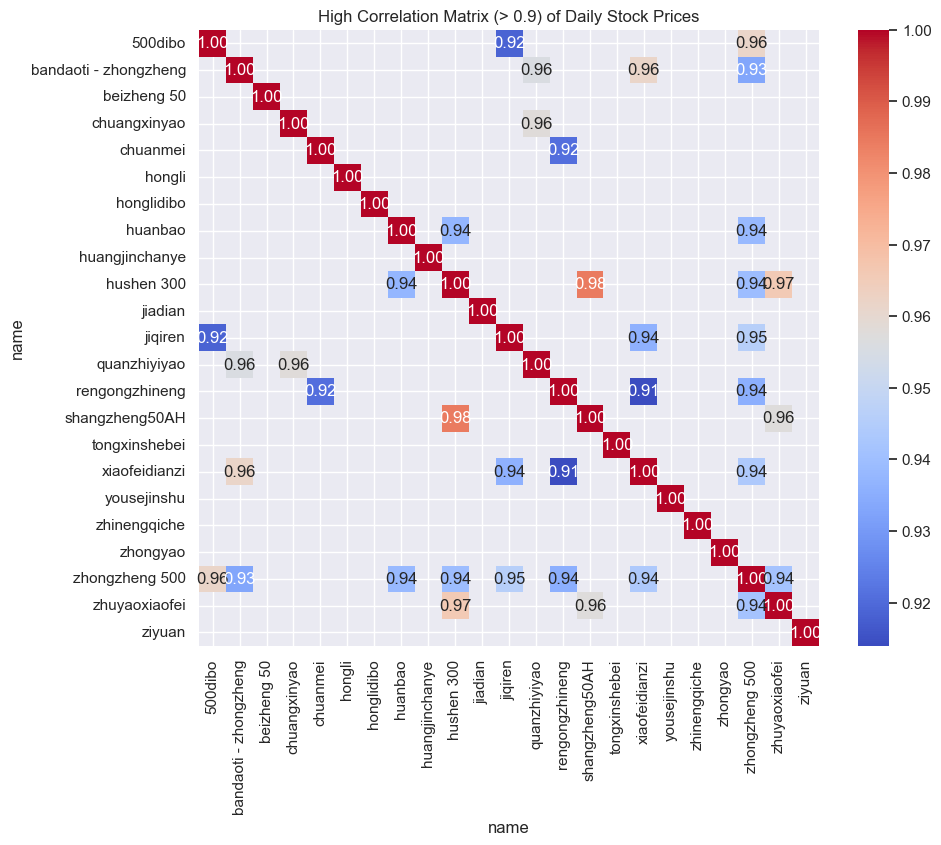

In [8]:
pivot_df = df_fund[df_fund['date']>='2023-04-01'][['date','NAV', 'name']].pivot(index='date', columns='name', values='NAV')
correlation_matrix = pivot_df.corr()

high_correlation = correlation_matrix[correlation_matrix >= 0.91]

plt.figure(figsize=(10, 8))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('High Correlation Matrix (> 0.9) of Daily Stock Prices')
plt.show()

In [9]:
df_fund_sub = df_fund[df_fund['date']>='2024-02-05']
print(df_fund_sub.shape)
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-02-05'][['name', 'NAV', 'NAV-Cum']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV', 'base_NAV-Cum']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']
# df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'relative_price'] = df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'NAV-Cum'] / df_fund_sub.loc[df_fund_sub['name'] == 'hongli', 'base_NAV-Cum']

df_fund_sub.head()

(1012, 6)


/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_8401/3251985981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


date     NAV  NAV-Cum change    code            name  base_NAV  \
0 2024-04-16  1.1982   1.1982  -2.59  007029  zhongzheng 500    1.0424   
1 2024-04-15  1.2301   1.2301   1.08  007029  zhongzheng 500    1.0424   
2 2024-04-12  1.2169   1.2169  -0.42  007029  zhongzheng 500    1.0424   
3 2024-04-11  1.2220   1.2220   0.49  007029  zhongzheng 500    1.0424   
4 2024-04-10  1.2161   1.2161  -1.19  007029  zhongzheng 500    1.0424   

   base_NAV-Cum  relative_price  
0        1.0424        1.149463  
1        1.0424        1.180065  
2        1.0424        1.167402  
3        1.0424        1.172295  
4        1.0424        1.166635

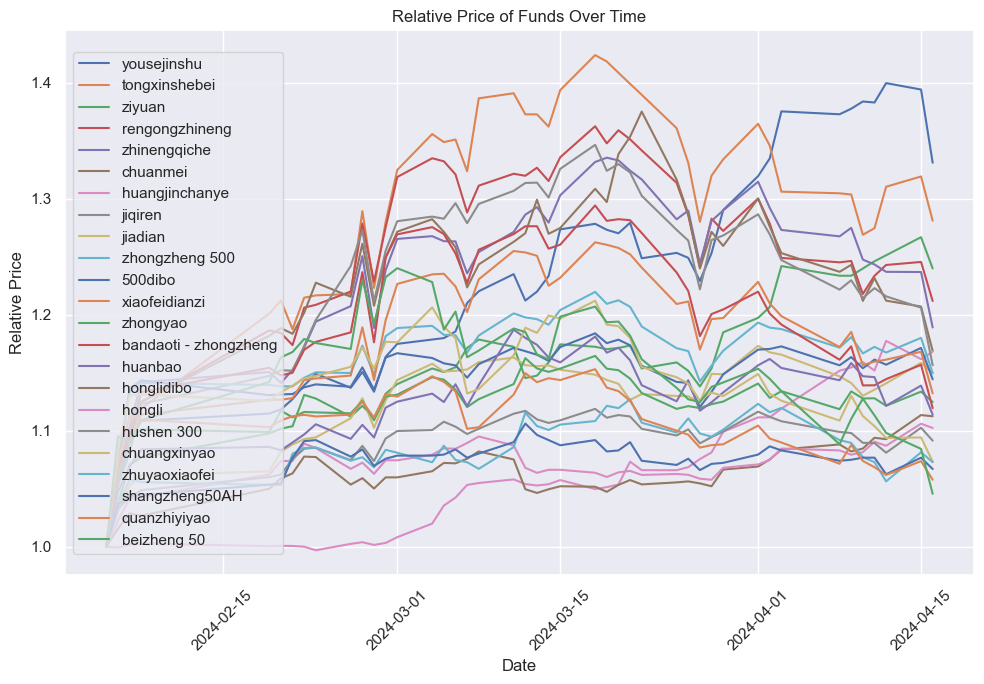

In [10]:
# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10,7))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='center left')

# Show plot
plt.tight_layout()
plt.show()

In [11]:
# Also check increase rate from 2024-02-05 to peak

sorted_data.merge(
    df_fund_sub.groupby('name')['relative_price'].max().reset_index().rename(columns={'relative_price':'peak_relative_price'}),
    on='name'
)

date       NAV   NAV-Cum change    code                   name  \
0  2024-04-16  0.748200  0.748200  -4.53  013438            yousejinshu   
1  2024-04-16  1.085500  1.085500  -2.89  007818          tongxinshebei   
2  2024-04-16  1.194000  1.194000  -2.13  012808                 ziyuan   
3  2024-04-16  0.828097  0.828097  -2.83  008021         rengongzhineng   
4  2024-04-16  0.711400  0.711400  -3.86  010956           zhinengqiche   
5  2024-04-16  0.695300  0.695300  -3.18  004753               chuanmei   
6  2024-04-16  1.903400  1.903400   0.55  000307         huangjinchanye   
7  2024-04-16  0.817000  0.817000  -4.12  018094                jiqiren   
8  2024-04-16  1.204300  1.204300  -0.74  005064                jiadian   
9  2024-04-16  1.198200  1.198200  -2.59  007029         zhongzheng 500   
10 2024-04-16  1.309742  1.309742   -2.3  003318                500dibo   
11 2024-04-16  0.905110  0.905110  -2.95  014907          xiaofeidianzi   
12 2024-04-16  0.872939  0.872939   -0.8  501012               zhongyao   
13 2024-04-16  1.324300  1.324300  -3.23  007301  bandaoti - zhongzheng   
14 2024-04-16  0.674400  0.674400   -2.2  002984                huanbao   
15 2024-04-16  1.929400  1.929400  -0.09  005562             honglidibo   
16 2024-04-16  1.240600  1.383600  -0.33  009052                 hongli   
17 2024-04-16  1.348400  1.348400  -1.01  007339             hushen 300   
18 2024-04-16  0.770090  0.770090  -1.98  012737           chuangxinyao   
19 2024-04-16  1.060000  1.060000  -0.79  009180          zhuyaoxiaofei   
20 2024-04-16  1.196000  1.196000  -0.91  501050         shangzheng50AH   
21 2024-04-16  0.744300  0.744300   -1.5  002978           quanzhiyiyao   
22 2024-04-16  0.835900  0.835900  -3.58  017513            beizheng 50   

    base_NAV  base_NAV-Cum  relative_price  peak_relative_price  
0   0.562100      0.562100        1.331080             1.399751  
1   0.847300      0.847300        1.281128             1.423935  
2   0.963000      0.963000        1.239875             1.266874  
3   0.683338      0.683338        1.211841             1.362561  
4   0.598300      0.598300        1.189036             1.335450  
5   0.594900      0.594900        1.168768             1.375189  
6   1.629400      1.629400        1.168160             1.177427  
7   0.706500      0.706500        1.156405             1.346497  
8   1.047300      1.047300        1.149909             1.173112  
9   1.042400      1.042400        1.149463             1.219685  
10  1.144626      1.144626        1.144253             1.183938  
11  0.799421      0.799421        1.132208             1.262453  
12  0.776137      0.776137        1.124723             1.164493  
13  1.183000      1.183000        1.119442             1.294252  
14  0.605500      0.605500        1.113790             1.187118  
15  1.734400      1.734400        1.112431             1.113469  
16  1.125400      1.268400        1.102364             1.106007  
17  1.235500      1.235500        1.091380             1.118818  
18  0.717521      0.717521        1.073265             1.212093  
19  0.988000      0.988000        1.072874             1.127024  
20  1.121000      1.121000        1.066905             1.106155  
21  0.703700      0.703700        1.057695             1.153048  
22  0.799500      0.799500        1.045528             1.240150

/var/folders/4r/jygz5t7n24724h42lgmbf1hw0000gn/T/ipykernel_8401/235088696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])


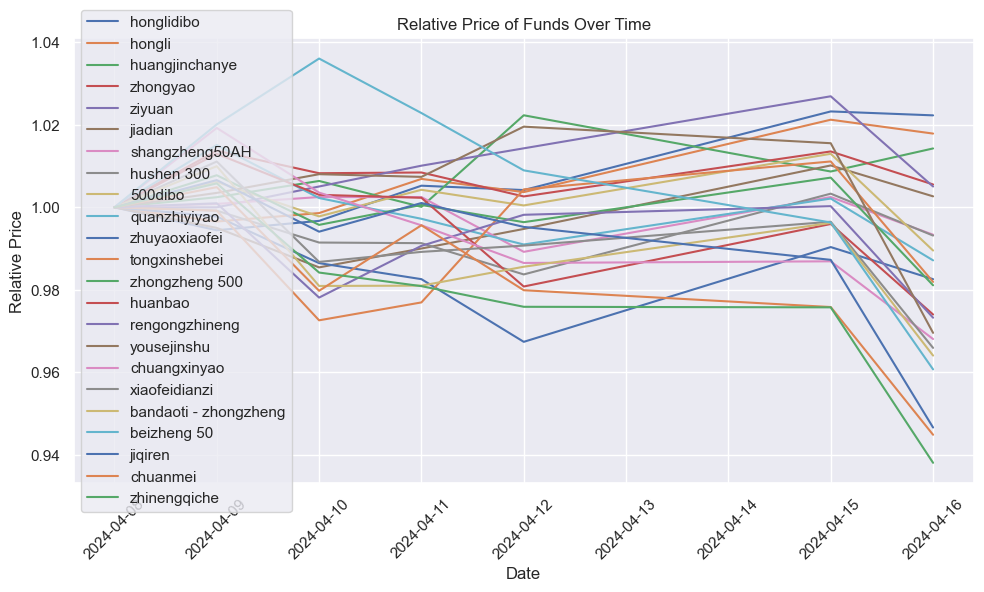

In [12]:
df_fund_sub = df_fund[df_fund['date']>='2024-04-08']
df_fund_sub['date'] = pd.to_datetime(df_fund_sub['date'])
base_nav = df_fund_sub[df_fund_sub['date'] == '2024-04-08'][['name', 'NAV']]

# Rename the 'stock_price' column to 'base_price'
base_nav.columns = ['name', 'base_NAV']

# Merge base_prices with the original DataFrame to get base prices for all dates
df_fund_sub = pd.merge(df_fund_sub, base_nav, on='name', how='left')

# Calculate the relative price ratio
df_fund_sub['relative_price'] = df_fund_sub['NAV'] / df_fund_sub['base_NAV']

# Assuming df contains the relative_price column and date column is already in datetime format
# Get a list of unique stock names

last_date = df_fund_sub['date'].max()
# Filter the DataFrame to get data only for the last date
last_date_data = df_fund_sub[df_fund_sub['date'] == last_date]
# Sort the data by relative_price in descending order
sorted_data = last_date_data.sort_values(by='relative_price', ascending=False)

# Get the sorted list of stock names
sorted_stock_names = sorted_data['name'].tolist()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each stock and plot its relative price over time
for name in sorted_stock_names:
    fund_data = df_fund_sub[df_fund_sub['name'] == name]
    ax.plot(fund_data['date'], fund_data['relative_price'], label=name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Relative Price')
ax.set_title('Relative Price of Funds Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='center left')

# Show plot
plt.tight_layout()
plt.show()

In [13]:
from kneed import KneeLocator
from sklearn.cluster import KMeans

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['NAV'][i] < data['NAV'][i - 1] and data['NAV'][i] < data['NAV'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['NAV'][i] > data['NAV'][i - 1] and data['NAV'][i] > data['NAV'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [14]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def stock_bollinger_move(stock_df, start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')):
    df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
    df = df.sort_values(by='date').reset_index()

    if df['name'].unique()[0] == 'hongli':
        df['daily_price'] = df['NAV-Cum']
    else:
        df['daily_price'] = df['NAV']

    
    print(datetime.today().strftime('%Y-%m-%d'))
    print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

    # Support and Resistance
    df = identify_weak_support_resistance(df)
    low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)
    
    high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    print(low_centers)
    print(high_centers)

    df['20 Day MA'] = df['daily_price'].rolling(window=20).mean()
    df['20 Day STD'] = df['daily_price'].rolling(window=20).std()

    df['50 Day MA'] = df['daily_price'].rolling(window=50).mean()
    df['50 Day STD'] = df['daily_price'].rolling(window=50).std()    
    
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band, 20MA:", df['Lower Band - 20MA'].tolist()[-1])
    print("Latest Higher Bollinger Band, 20MA:", df['Upper Band - 20MA'].tolist()[-1])
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
    print("Latest 50 Day MA:", df['50 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band, 50MA:", df['Lower Band - 50MA'].tolist()[-1])
    print("Latest Higher Bollinger Band, 50MA:", df['Upper Band - 50MA'].tolist()[-1])
    
    fig, ax = plt.subplots(figsize=(32,8))
    ax.grid(True, alpha=0.5)
    ax.set_title(stock_df['name'].unique()[0])
    ax.plot(df['date'], df['daily_price'], label='Daily Price')
    ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')

    ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
    ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
    ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
    ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
    ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
    ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')
    
    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')

    ax.legend()


zhongzheng 500
2024-04-17
* previous stock price closing 1.2
[[1.19685263]
 [1.29867838]
 [1.3723541 ]
 [1.43876667]
 [1.55024483]]
[[1.22631111]
 [1.31459722]
 [1.38827656]
 [1.45611892]
 [1.56567   ]]
Latest 20 Day MA: 1.23021
Latest Lower Bollinger Band, 20MA: 1.1865245742718002
Latest Higher Bollinger Band, 20MA: 1.2738954257281998
Latest 50 Day MA: 1.205236
Latest Lower Bollinger Band, 50MA: 1.0762461870815403
Latest Higher Bollinger Band, 50MA: 1.3342258129184597


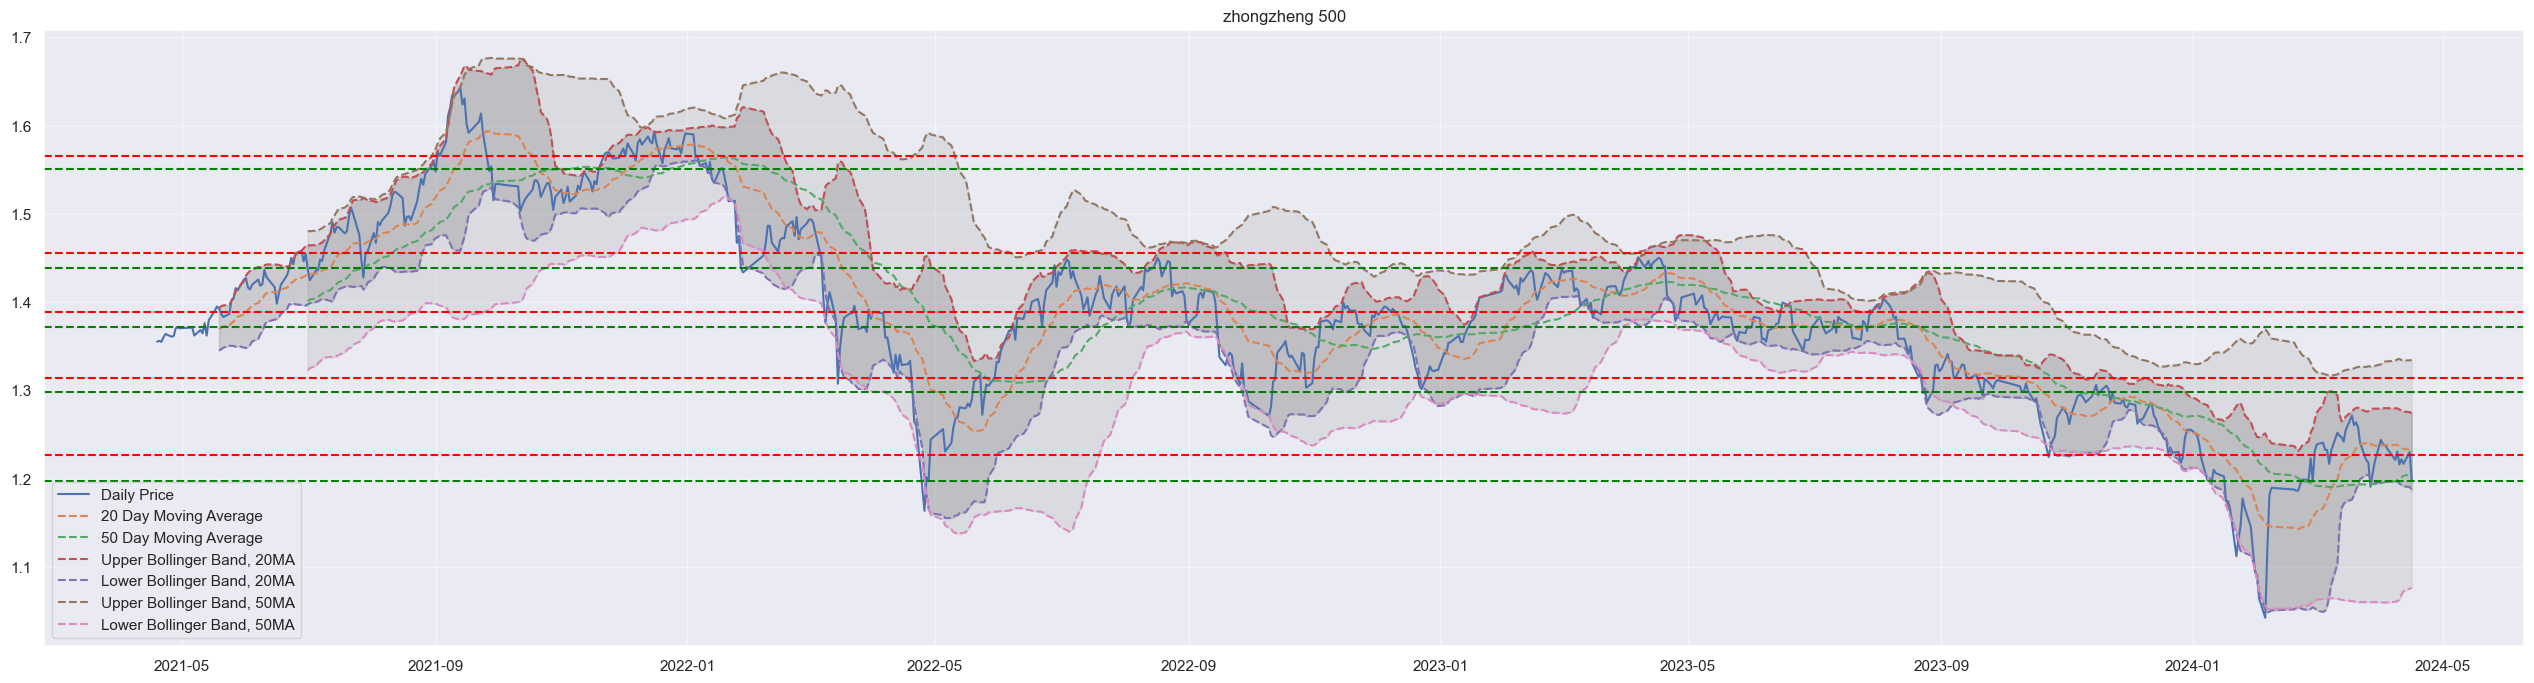

In [15]:
# solid buy 1.19
# sell at 1.24
print(df_fund["name"].unique().tolist()[0])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[0]])

500dibo
2024-04-17
* previous stock price closing 1.31
[[1.21726596]
 [1.29259522]
 [1.36985308]
 [1.4212398 ]]
[[1.29472384]
 [1.37269901]
 [1.43121705]]
Latest 20 Day MA: 1.3262734221302928
Latest Lower Bollinger Band, 20MA: 1.2883387311979009
Latest Higher Bollinger Band, 20MA: 1.3642081130626846
Latest 50 Day MA: 1.3041922986696648
Latest Lower Bollinger Band, 50MA: 1.1869041718132947
Latest Higher Bollinger Band, 50MA: 1.421480425526035


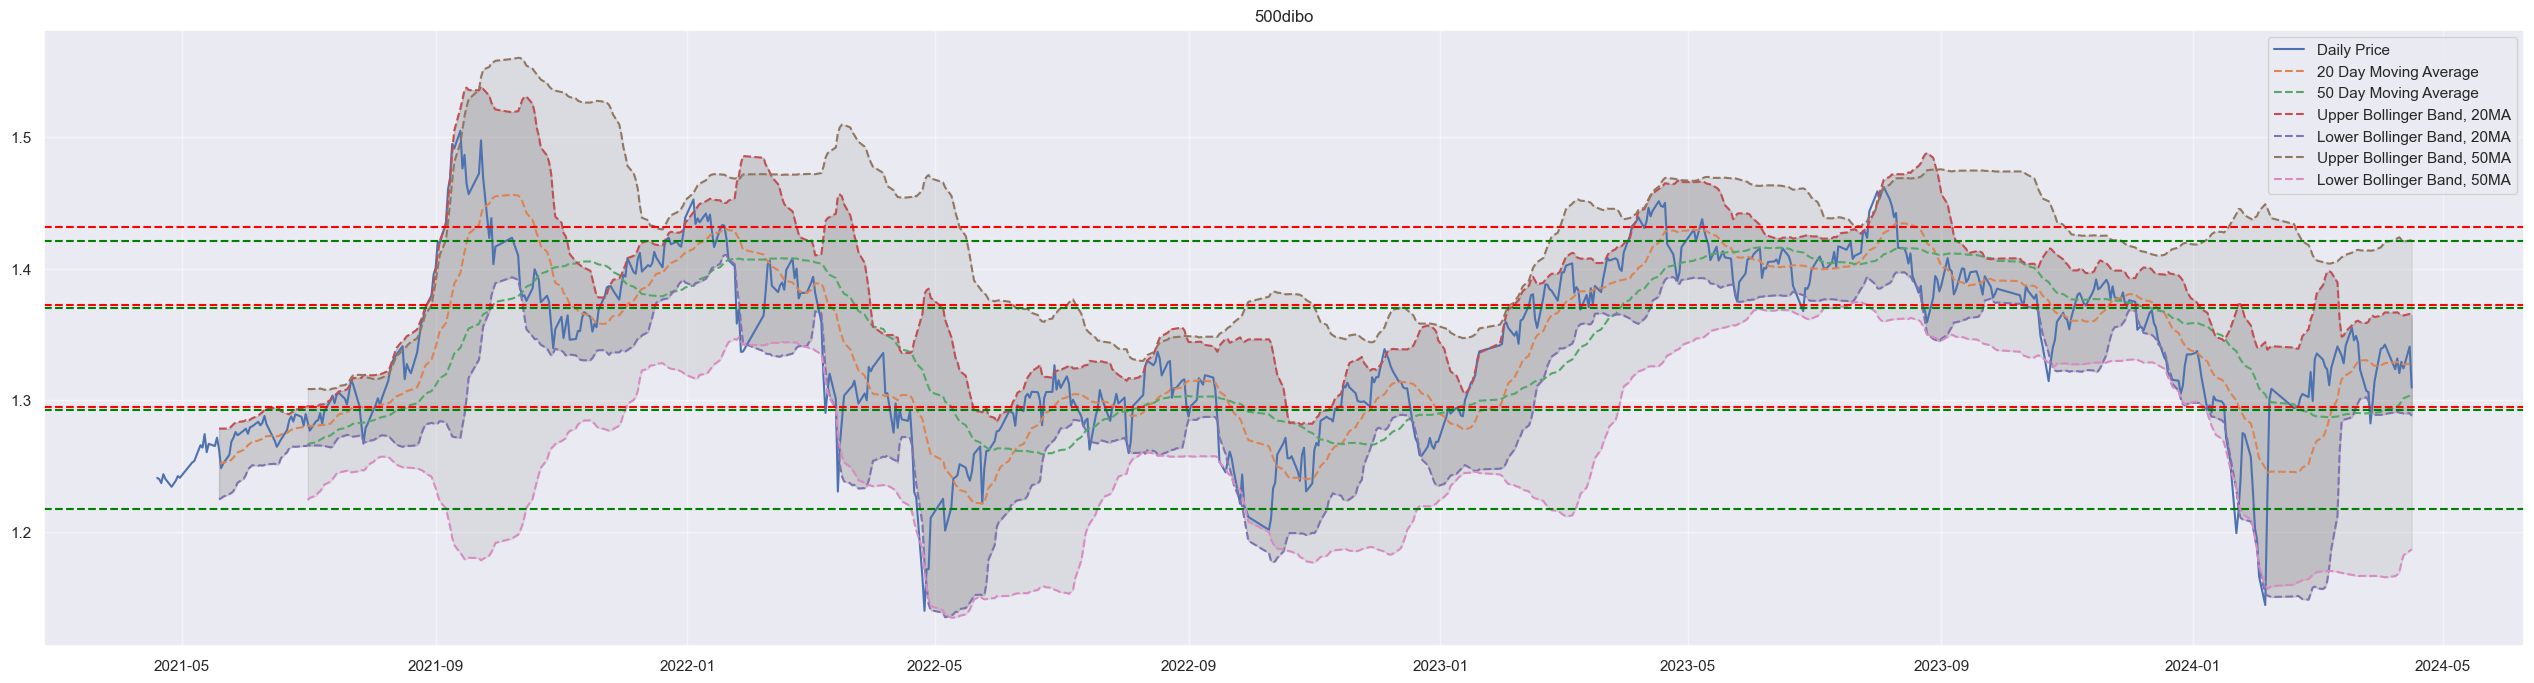

In [16]:
# solid buy at Lower Bollinger Band: 1.29
# sell at Higher Bollinger Band: 1.365
print(df_fund["name"].unique().tolist()[1])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[1]])

bandaoti - zhongzheng
2024-04-17
* previous stock price closing 1.32
[[1.2131    ]
 [1.403525  ]
 [1.59170455]
 [1.70583243]
 [1.82113077]
 [1.93932143]
 [2.10092105]
 [2.29178182]
 [2.45657619]
 [2.61678   ]]
[[1.42667857]
 [1.6573871 ]
 [1.758272  ]
 [1.85292368]
 [1.97601875]
 [2.14144211]
 [2.2916375 ]
 [2.46736842]
 [2.63062857]
 [2.82623333]]
Latest 20 Day MA: 1.425435
Latest Lower Bollinger Band, 20MA: 1.295787148616228
Latest Higher Bollinger Band, 20MA: 1.555082851383772
Latest 50 Day MA: 1.405858
Latest Lower Bollinger Band, 50MA: 1.1828588174149126
Latest Higher Bollinger Band, 50MA: 1.6288571825850875


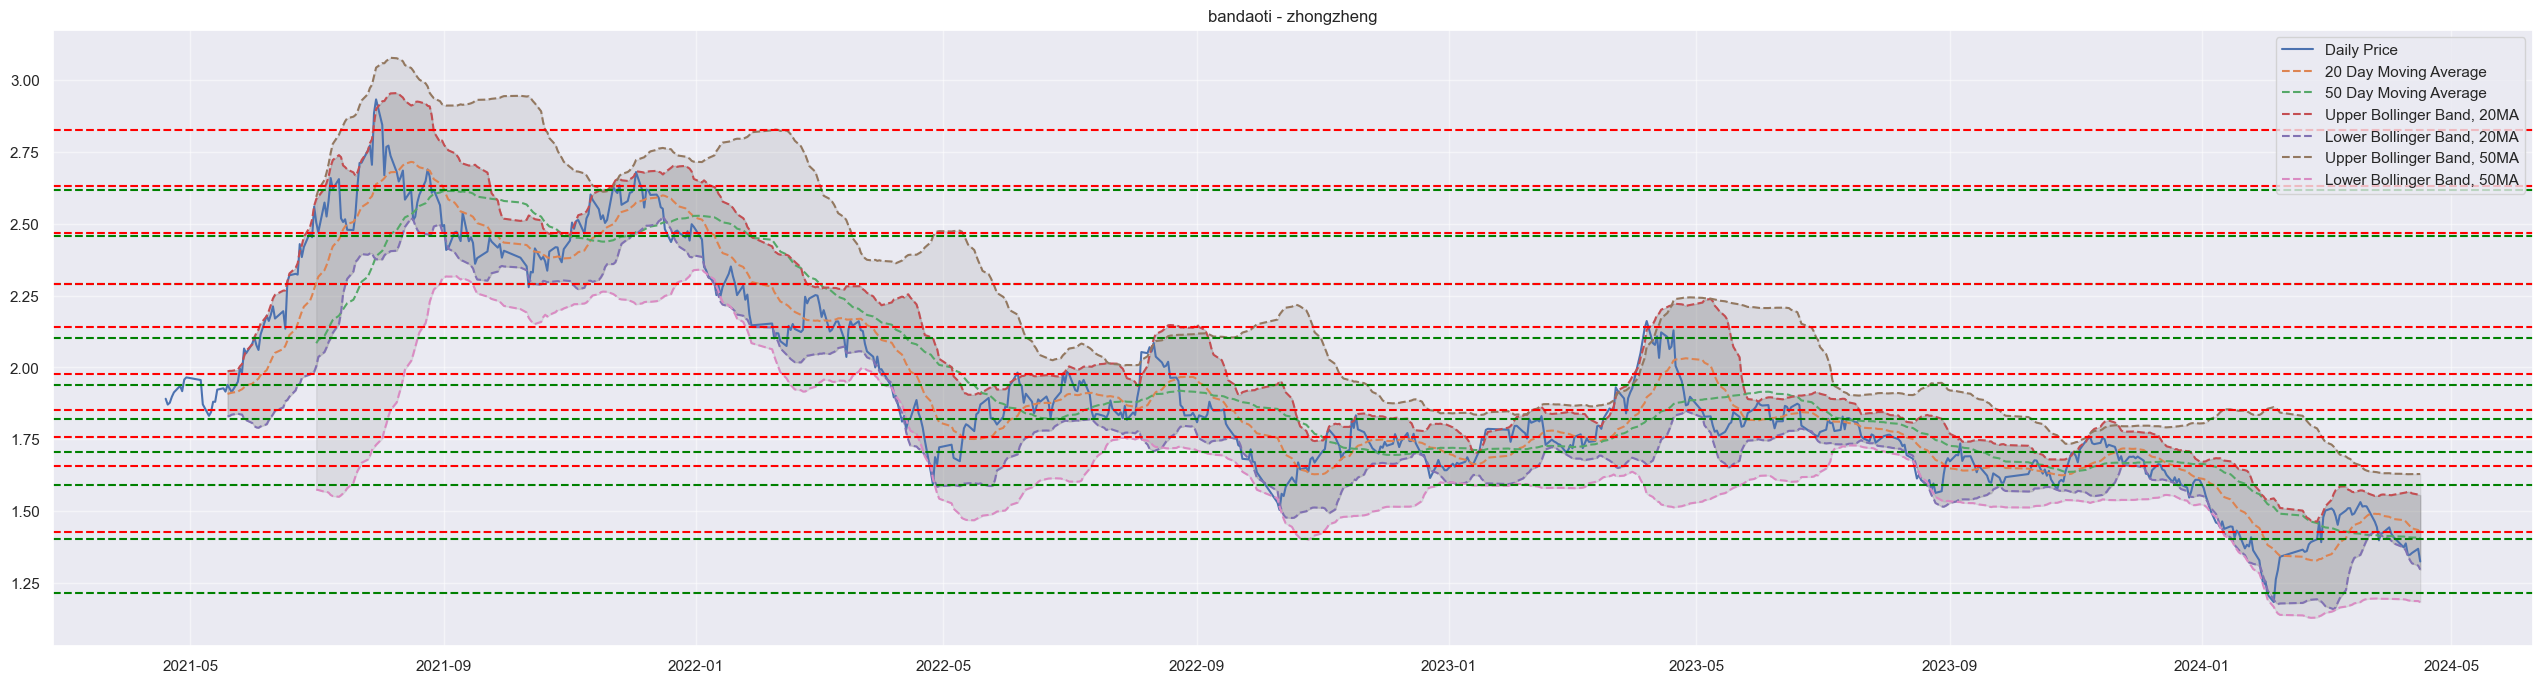

In [17]:
print(df_fund["name"].unique().tolist()[2])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[2]])

zhinengqiche
2024-04-17
* previous stock price closing 0.71
[[0.71887391]
 [0.79947222]
 [0.86998868]
 [0.95916333]
 [1.06809375]]
[[0.78189091]
 [0.87155072]
 [0.97442   ]
 [1.08904706]]
Latest 20 Day MA: 0.765965
Latest Lower Bollinger Band, 20MA: 0.7189408729340363
Latest Higher Bollinger Band, 20MA: 0.8129891270659637
Latest 50 Day MA: 0.732076
Latest Lower Bollinger Band, 50MA: 0.6060839715835713
Latest Higher Bollinger Band, 50MA: 0.8580680284164286


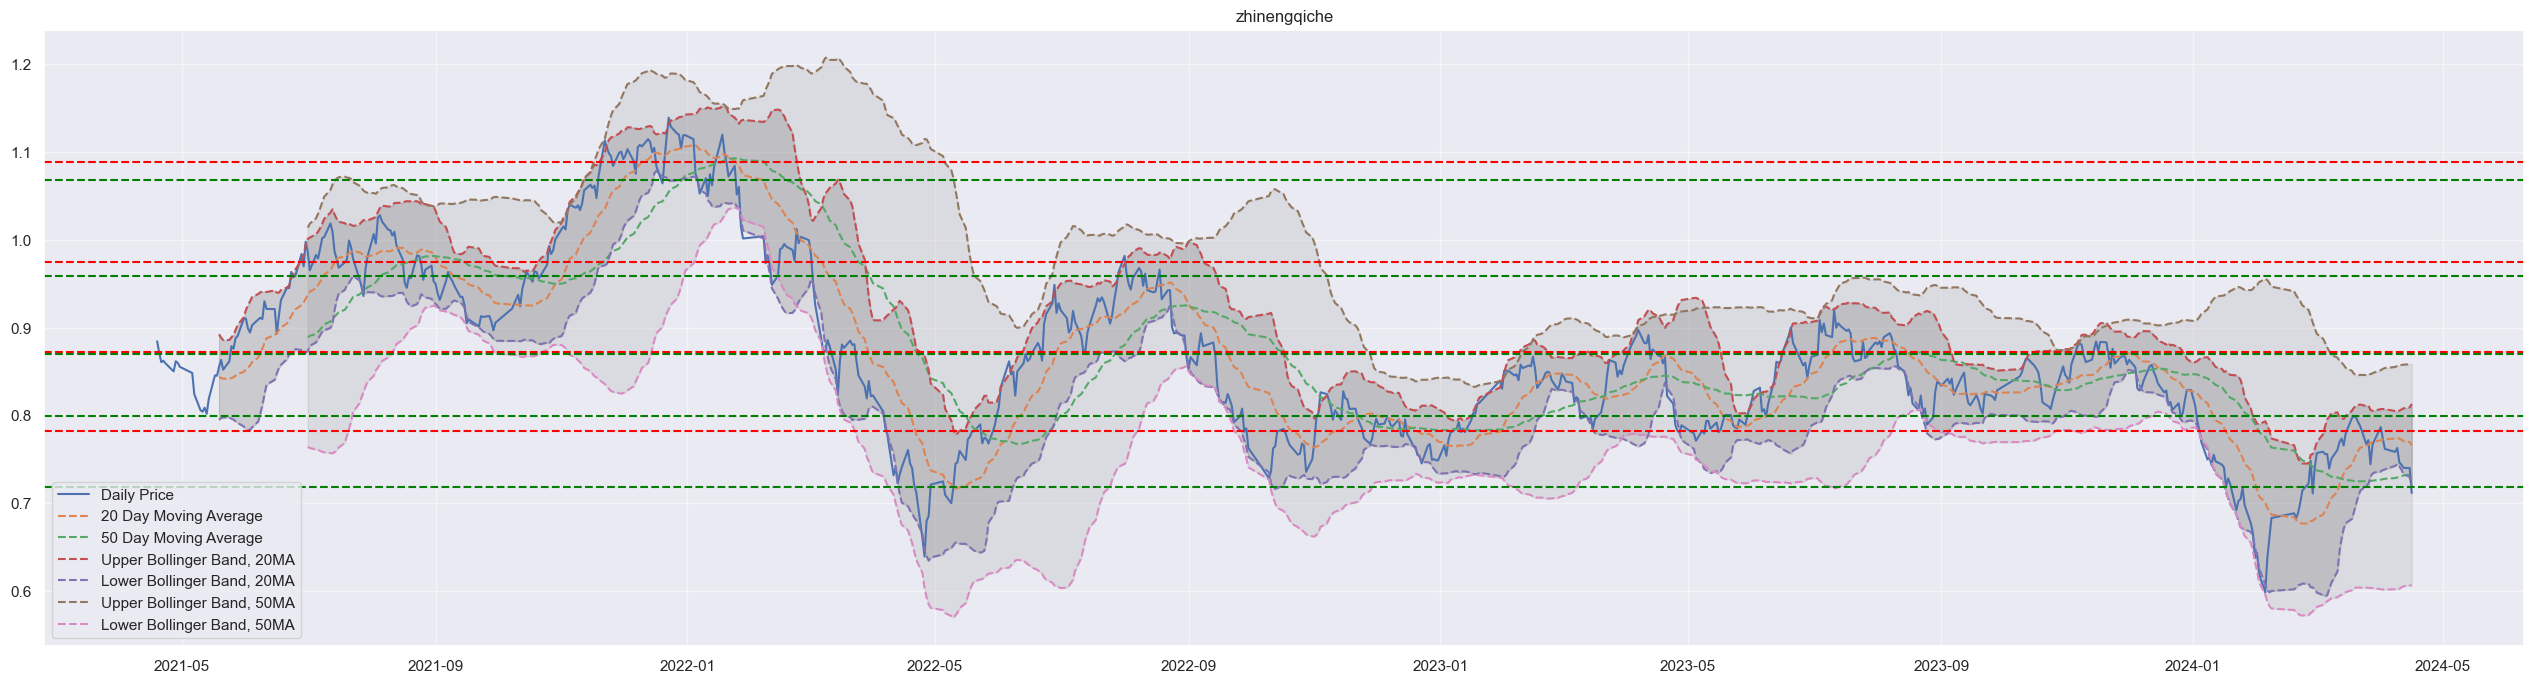

In [18]:
# sell 0.8
# try buy 0.74
print(df_fund["name"].unique().tolist()[3])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[3]])

huanbao
2024-04-17
* previous stock price closing 0.67
[[0.67942963]
 [0.75913846]
 [0.89345385]
 [1.01795937]
 [1.12090357]
 [1.2303    ]
 [1.32263077]]
[[0.71387692]
 [0.89911622]
 [1.03629487]
 [1.16006154]
 [1.26206552]
 [1.34730714]]
Latest 20 Day MA: 0.6934549999999999
Latest Lower Bollinger Band, 20MA: 0.6706164845169373
Latest Higher Bollinger Band, 20MA: 0.7162935154830625
Latest 50 Day MA: 0.6772119999999999
Latest Lower Bollinger Band, 50MA: 0.6091539957772976
Latest Higher Bollinger Band, 50MA: 0.7452700042227023


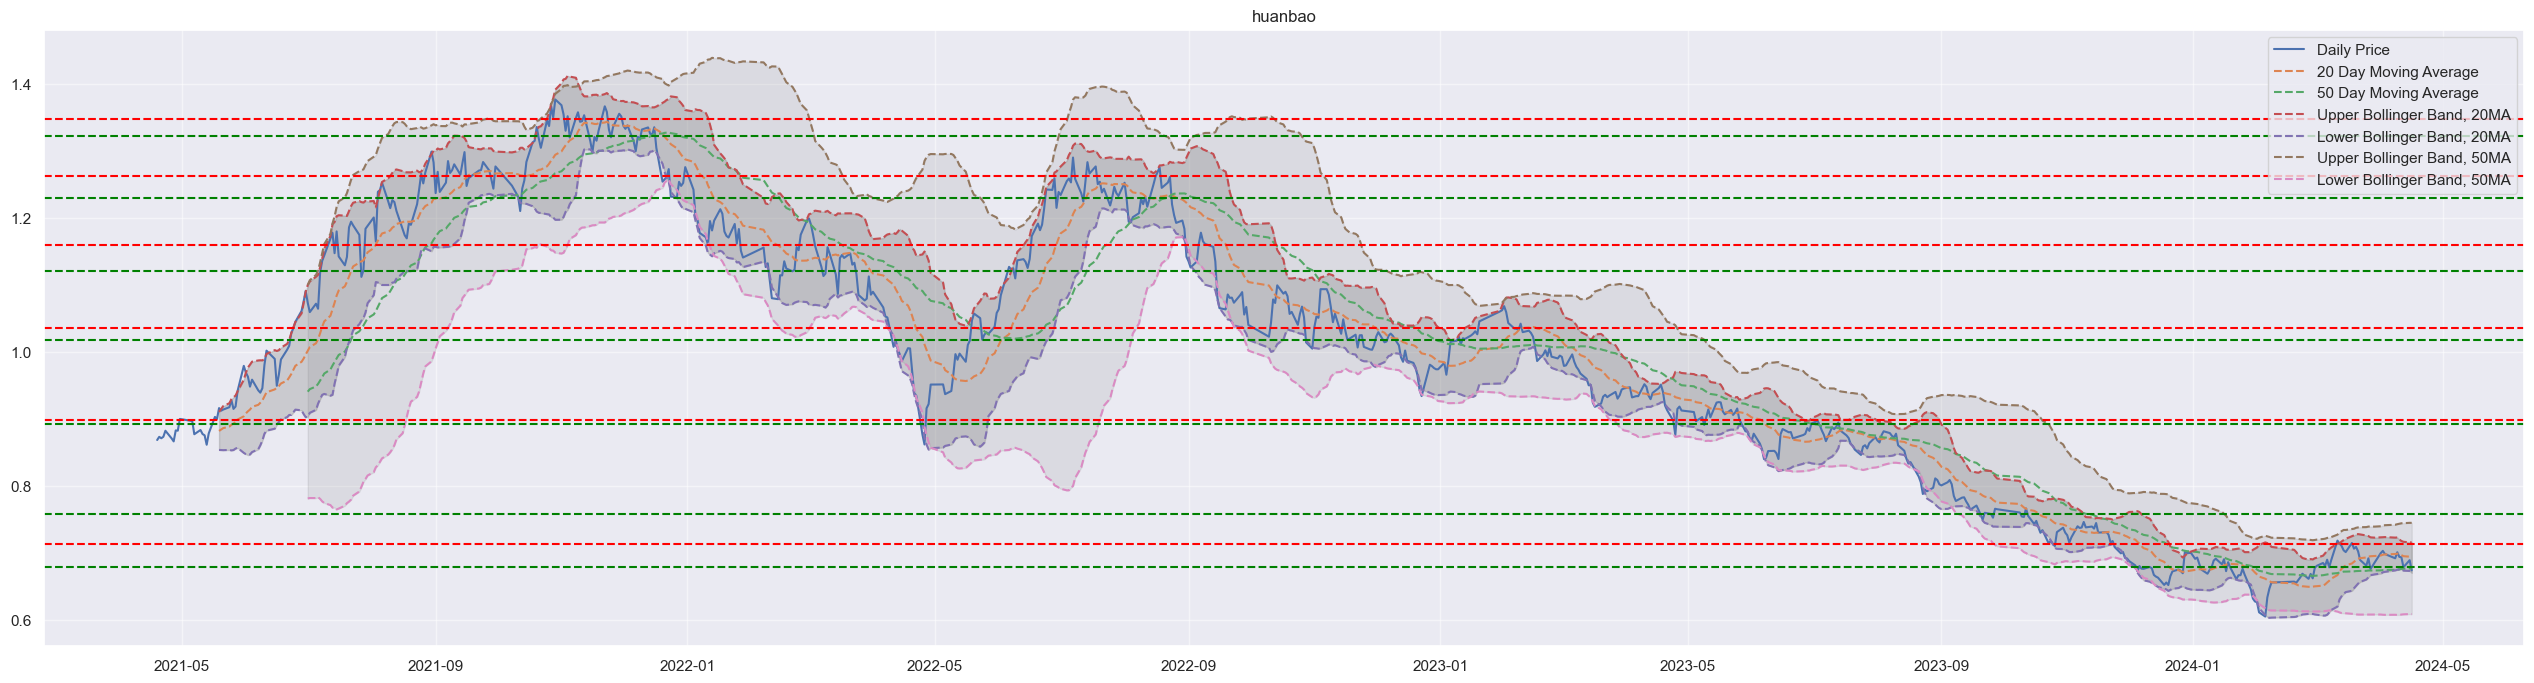

In [19]:
# solid buy at 0.67; sell between 0.715 - 0.72
print(df_fund["name"].unique().tolist()[4])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[4]])

jiqiren
2024-04-17
* previous stock price closing 0.82
[[0.81836364]
 [0.94716429]
 [1.04715   ]]
[[0.86871333]
 [0.97950833]
 [1.06833636]]
Latest 20 Day MA: 0.889765
Latest Lower Bollinger Band, 20MA: 0.8199811449828667
Latest Higher Bollinger Band, 20MA: 0.9595488550171334
Latest 50 Day MA: 0.862204
Latest Lower Bollinger Band, 50MA: 0.703478102263545
Latest Higher Bollinger Band, 50MA: 1.020929897736455


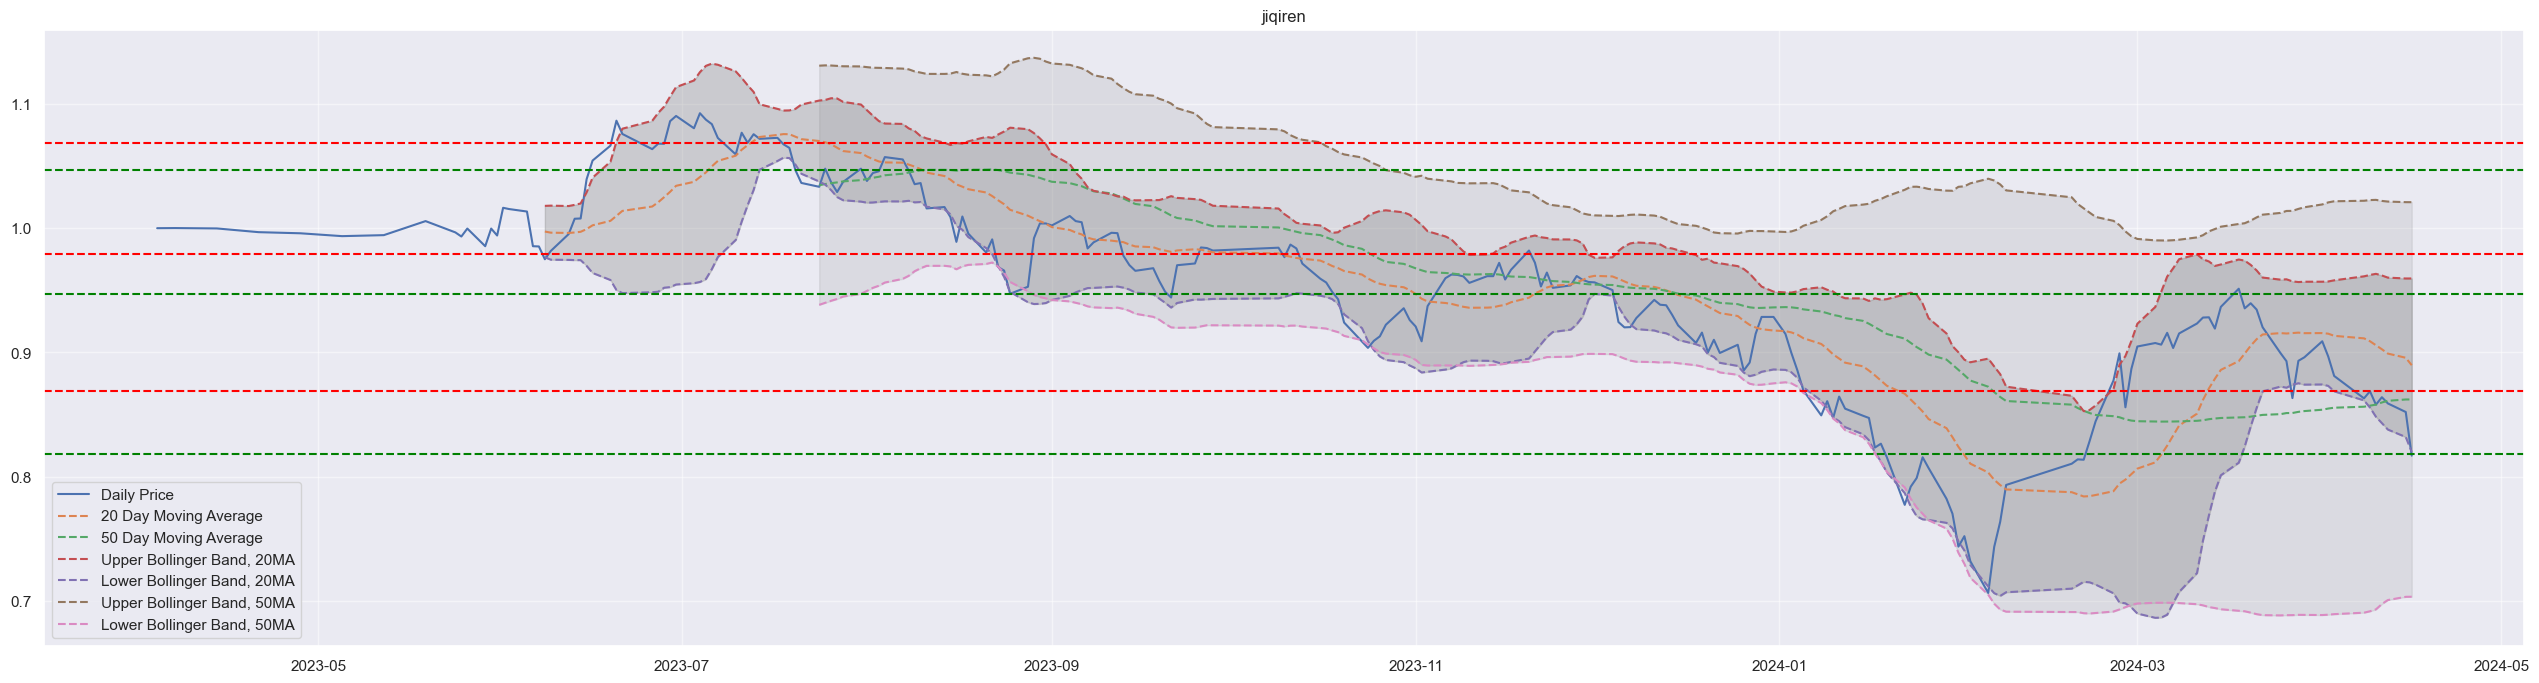

In [20]:
# bought 0.86
print(df_fund["name"].unique().tolist()[5])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[5]])

xiaofeidianzi
2024-04-17
* previous stock price closing 0.91
[[0.91550198]
 [1.02363387]
 [1.11084185]
 [1.22321281]]
[[0.94089877]
 [1.04255333]
 [1.12703206]
 [1.23664558]]
Latest 20 Day MA: 0.9604796095970493
Latest Lower Bollinger Band, 20MA: 0.8981745748424894
Latest Higher Bollinger Band, 20MA: 1.022784644351609
Latest 50 Day MA: 0.9360669091339084
Latest Lower Bollinger Band, 50MA: 0.7958594626056466
Latest Higher Bollinger Band, 50MA: 1.0762743556621703


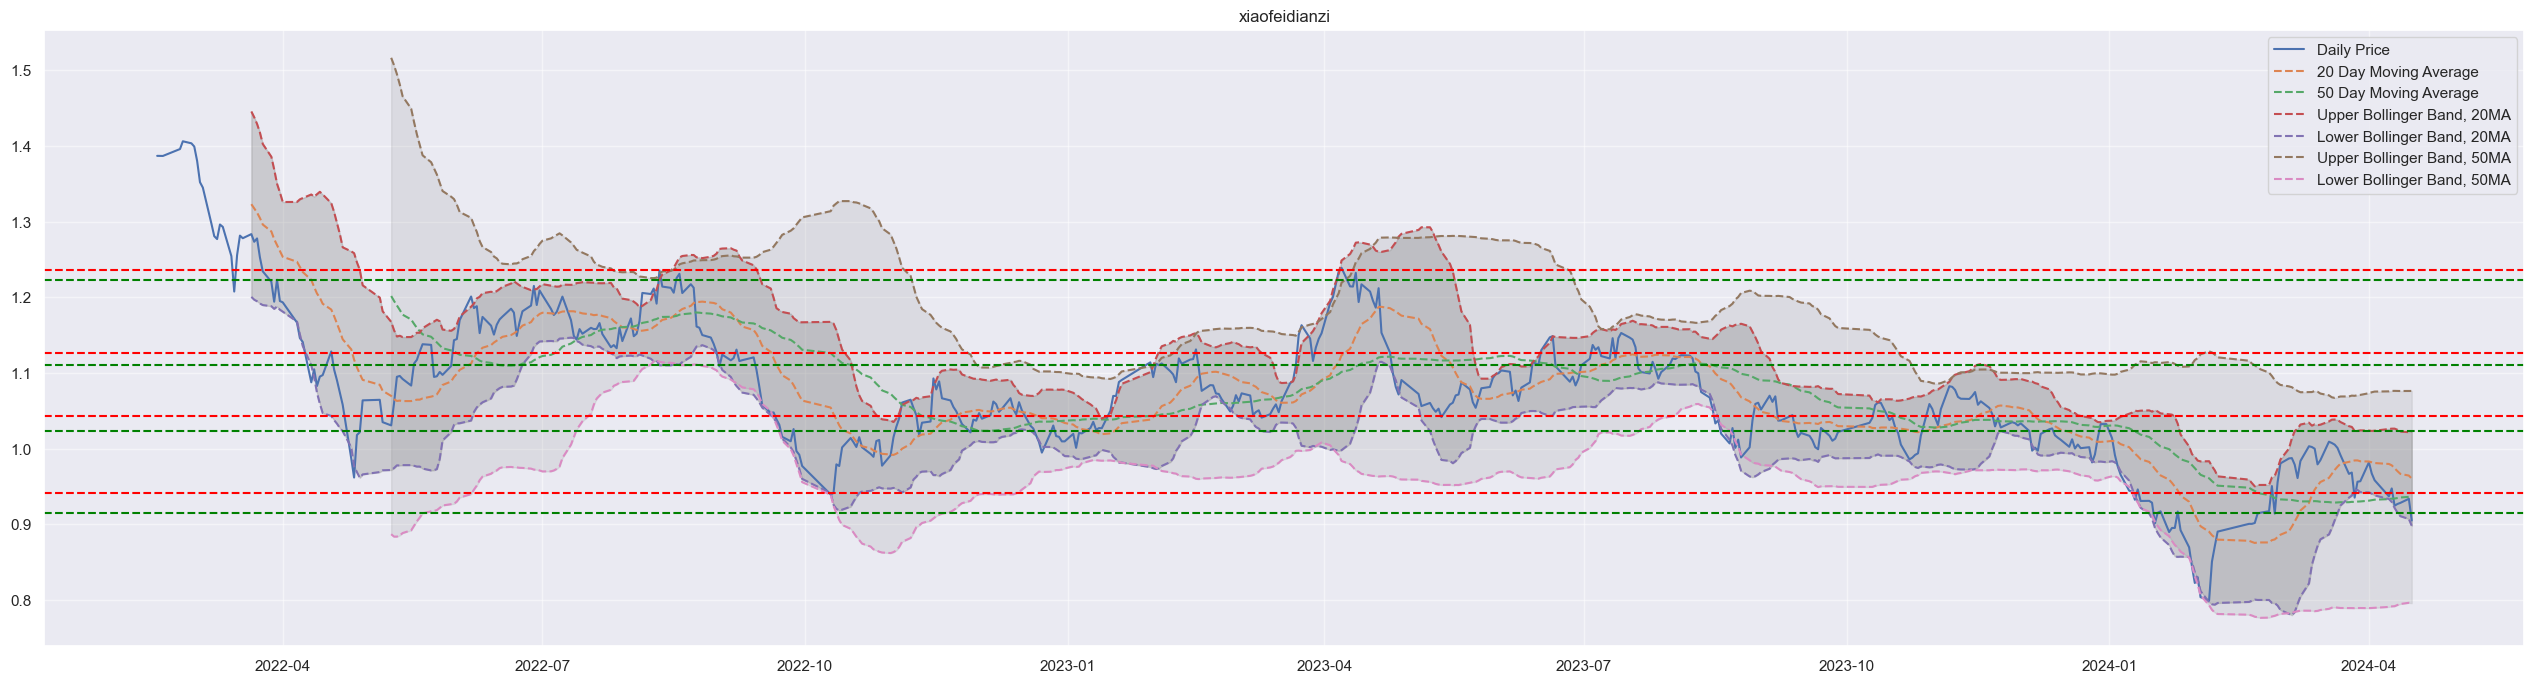

In [21]:
# bought at Lower Bollinger Band: 0.930
# try sell at 20 Day MA: 0.9781

print(df_fund["name"].unique().tolist()[6])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[6]])

rengongzhineng
2024-04-17
* previous stock price closing 0.83
[[0.77542694]
 [0.86338724]
 [0.94145151]
 [1.0404888 ]
 [1.14045926]
 [1.22215327]]
[[0.83023232]
 [0.91175087]
 [1.00117447]
 [1.13594506]
 [1.23461445]]
Latest 20 Day MA: 0.8756771451850277
Latest Lower Bollinger Band, 20MA: 0.8082768979370618
Latest Higher Bollinger Band, 20MA: 0.9430773924329936
Latest 50 Day MA: 0.8449526461832102
Latest Lower Bollinger Band, 50MA: 0.6771960183953276
Latest Higher Bollinger Band, 50MA: 1.0127092739710928


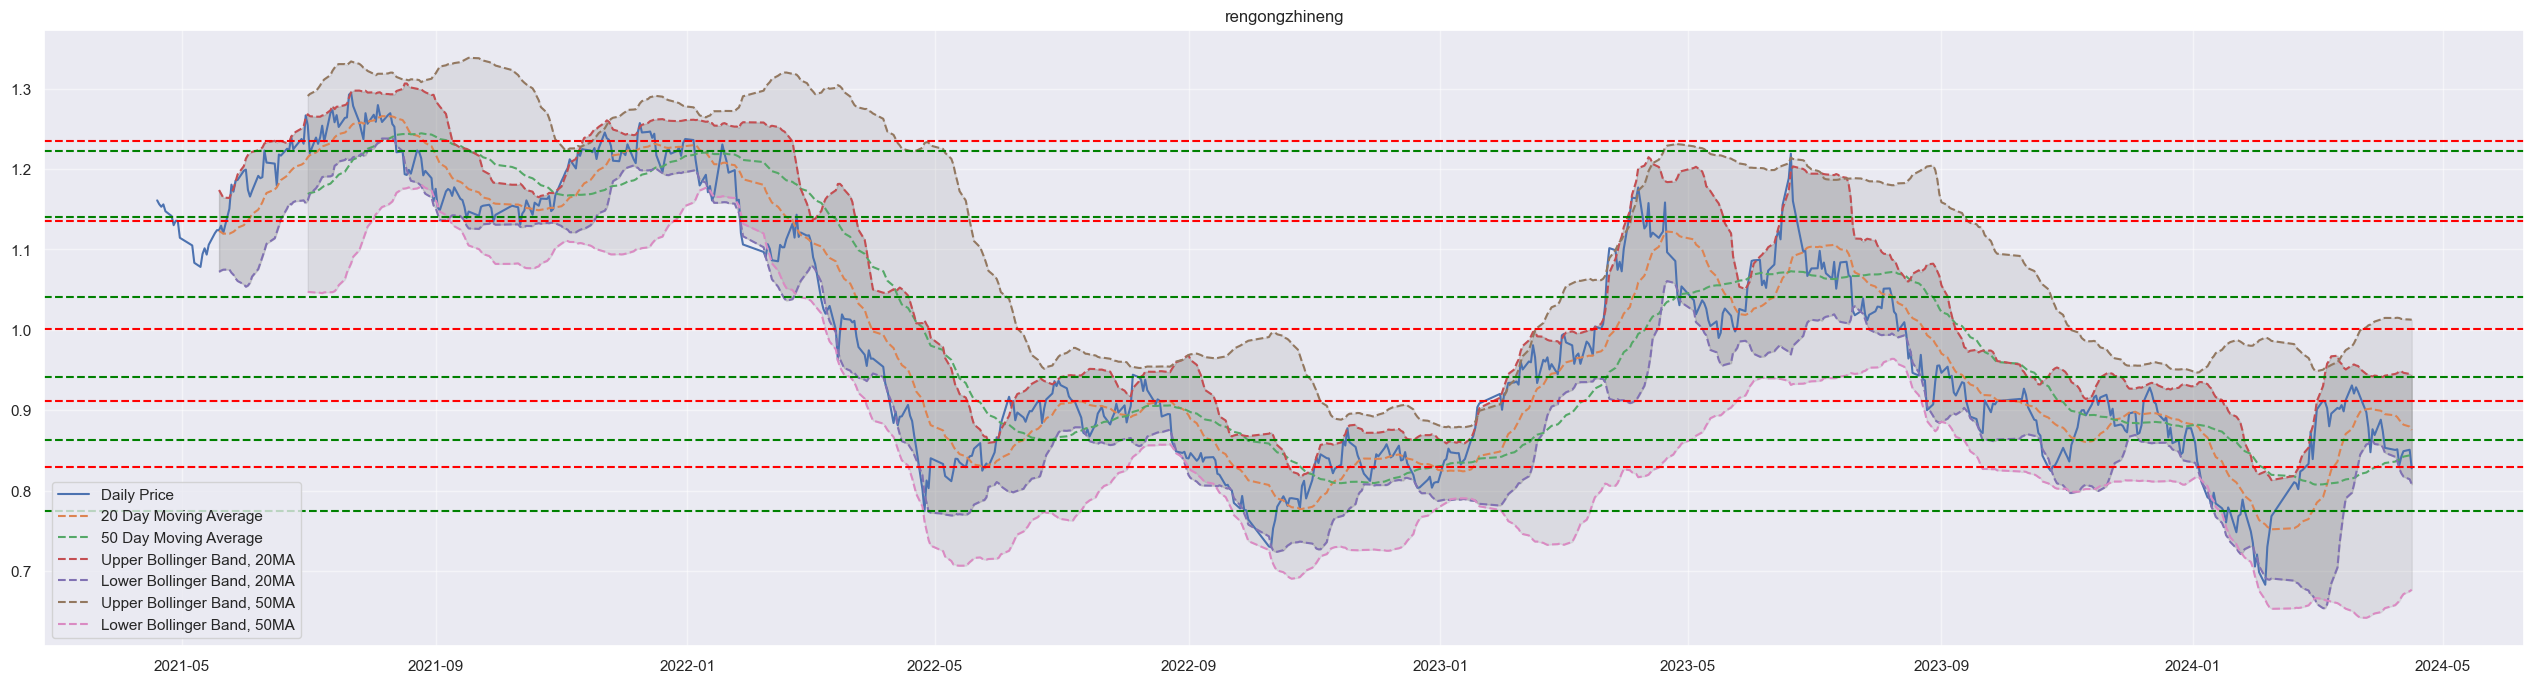

In [22]:
# bought at Lower Bollinger Band: 0.85
# try sell at 20 Day MA: 0.892

print(df_fund["name"].unique().tolist()[7])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[7]])

hushen 300
2024-04-17
* previous stock price closing 1.35
[[1.26739167]
 [1.36752857]
 [1.45030465]
 [1.53301628]
 [1.65718889]
 [1.75534118]
 [1.82683684]]
[[1.28116   ]
 [1.38244074]
 [1.46826047]
 [1.5502    ]
 [1.67347   ]
 [1.7754    ]
 [1.84596667]]
Latest 20 Day MA: 1.36056
Latest Lower Bollinger Band, 20MA: 1.3345902686312554
Latest Higher Bollinger Band, 20MA: 1.3865297313687446
Latest 50 Day MA: 1.336812
Latest Lower Bollinger Band, 50MA: 1.2305351229672497
Latest Higher Bollinger Band, 50MA: 1.4430888770327501


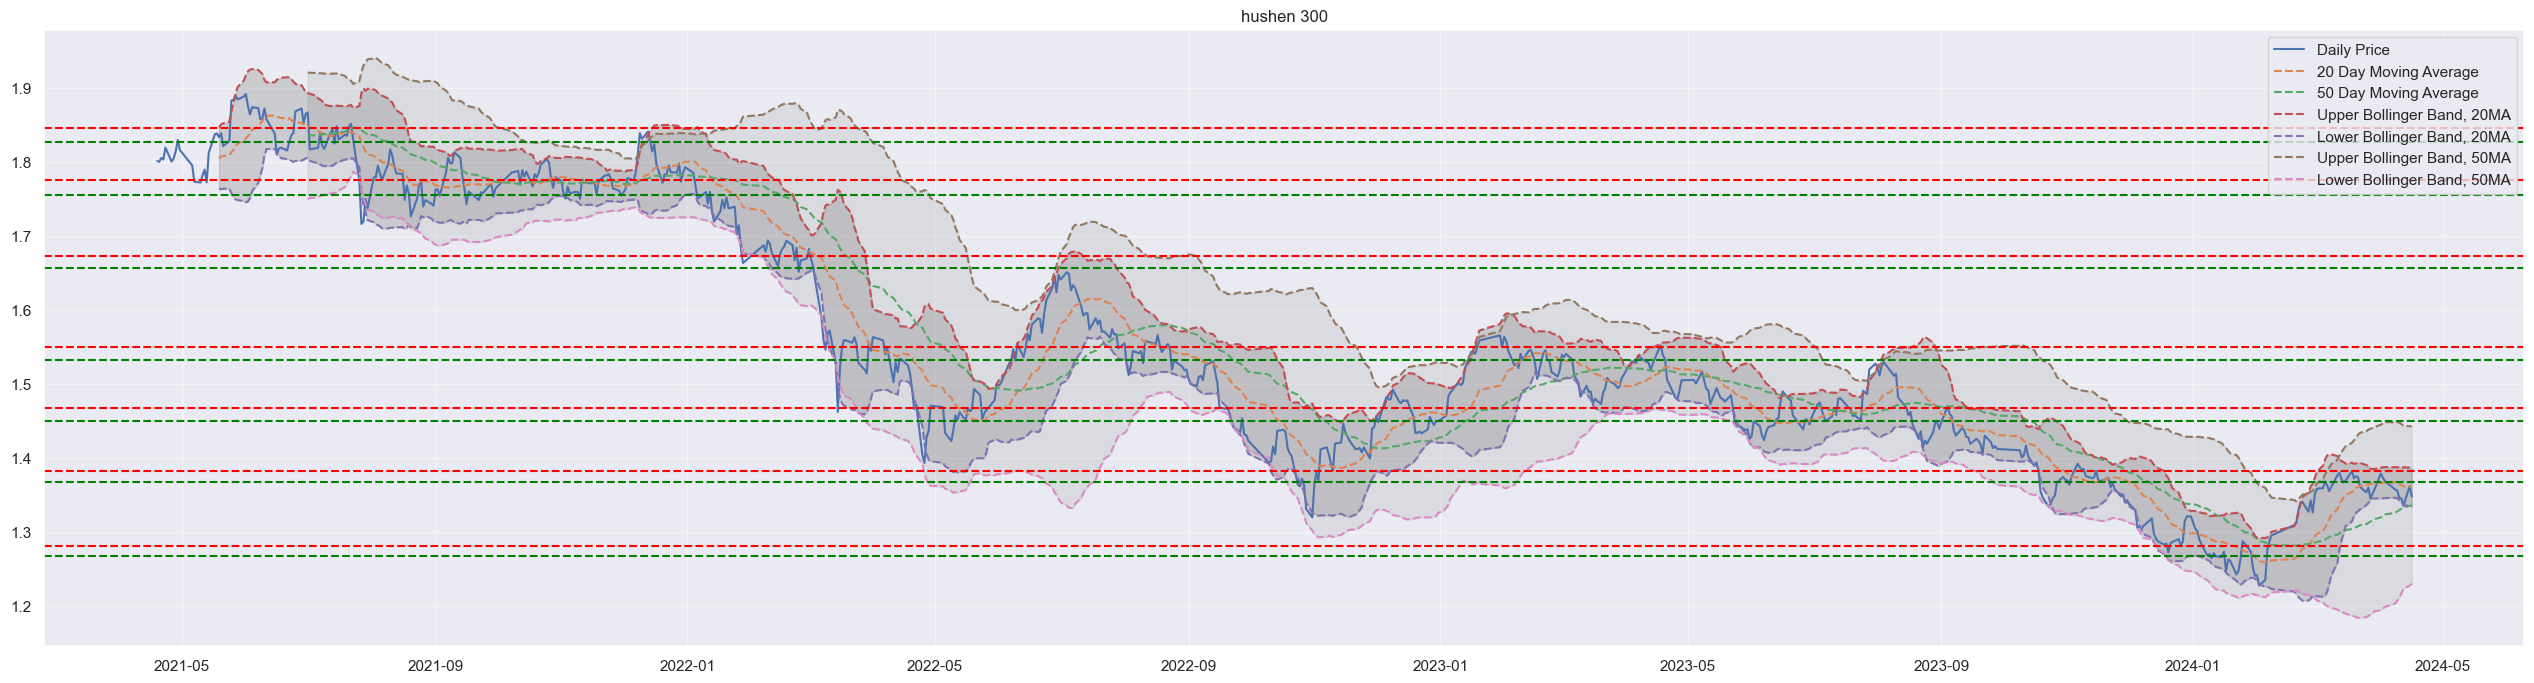

In [23]:
# 1.385 sell
# buy at lower bollinger band at 1.343

print(df_fund["name"].unique().tolist()[8])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[8]])

zhuyaoxiaofei
2024-04-17
* previous stock price closing 1.06
[[1.04061818]
 [1.15248611]
 [1.24345227]
 [1.31578276]
 [1.40860333]
 [1.52016667]]
[[1.06466818]
 [1.16301071]
 [1.25683333]
 [1.33694839]
 [1.4218    ]
 [1.53271579]]
Latest 20 Day MA: 1.0861100000000001
Latest Lower Bollinger Band, 20MA: 1.0470371180323128
Latest Higher Bollinger Band, 20MA: 1.1251828819676875
Latest 50 Day MA: 1.06247
Latest Lower Bollinger Band, 50MA: 0.971286340162182
Latest Higher Bollinger Band, 50MA: 1.153653659837818


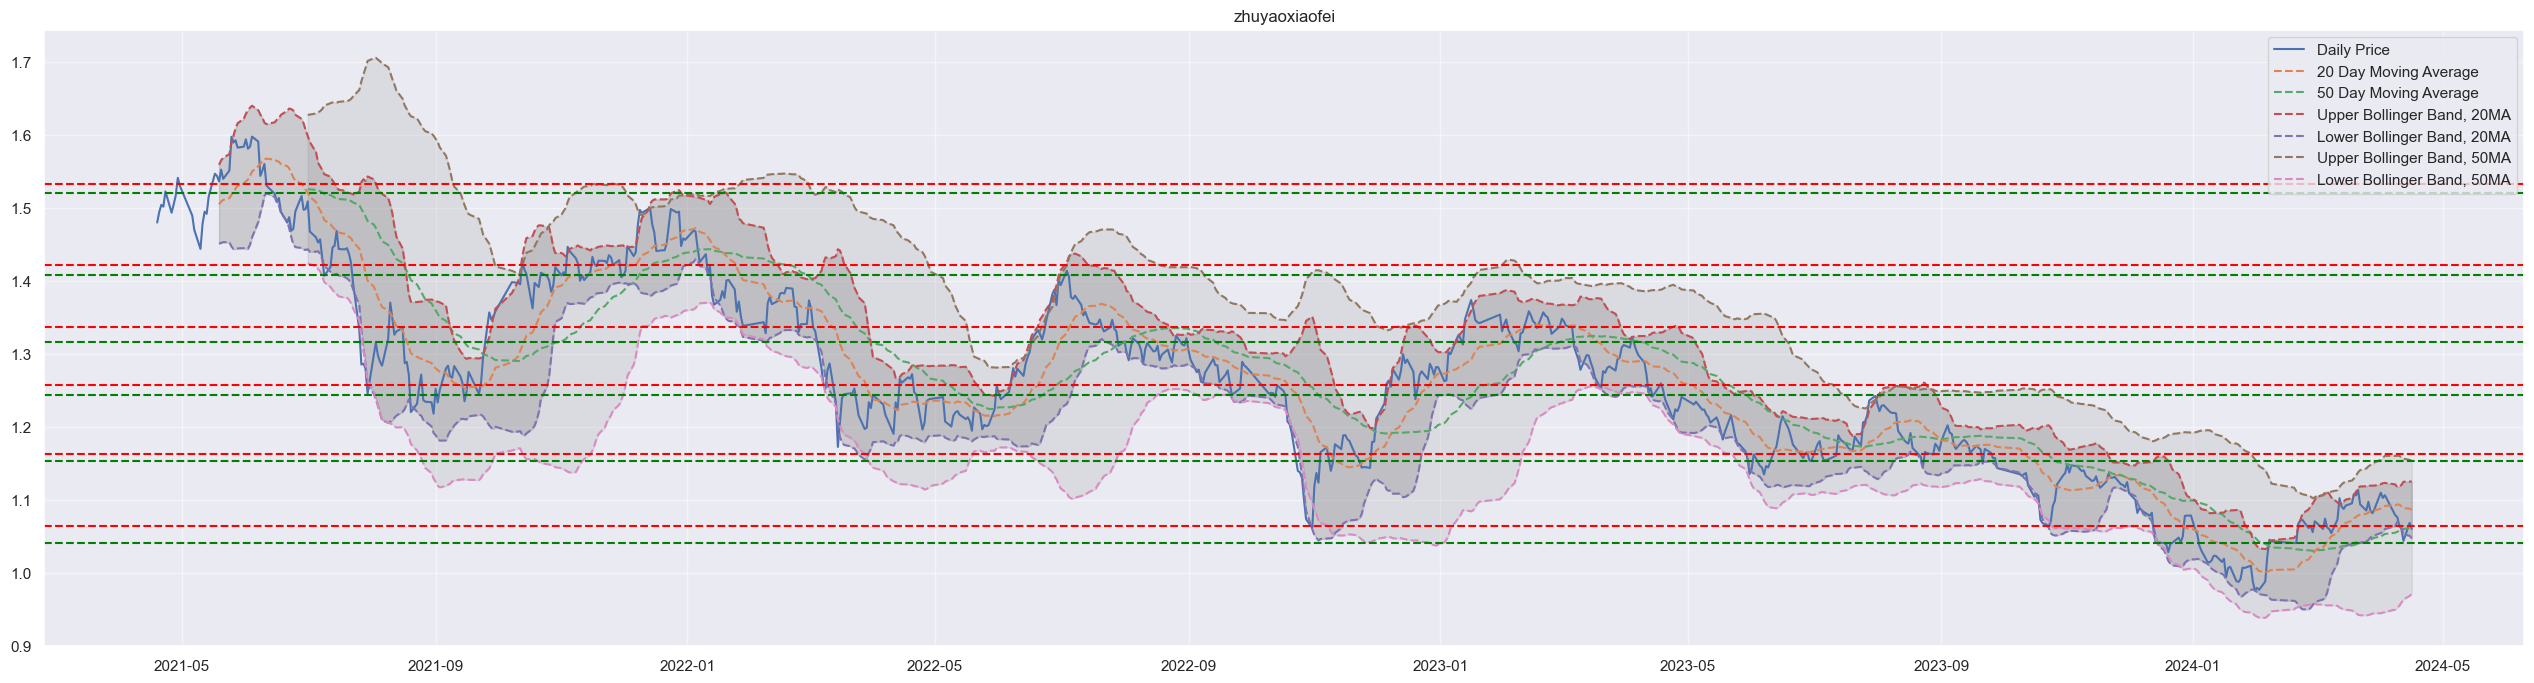

In [24]:
# Target sell: 1.12; buy: 1.067
print(df_fund["name"].unique().tolist()[10])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[10]])

jiadian
2024-04-17
* previous stock price closing 1.2
[[1.05838571]
 [1.13615556]
 [1.19056327]
 [1.2865871 ]
 [1.44035263]]
[[1.08785897]
 [1.16734821]
 [1.22956596]
 [1.3374381 ]
 [1.46677368]]
Latest 20 Day MA: 1.198165
Latest Lower Bollinger Band, 20MA: 1.168788369474088
Latest Higher Bollinger Band, 20MA: 1.227541630525912
Latest 50 Day MA: 1.1686020000000001
Latest Lower Bollinger Band, 50MA: 1.0412507513382274
Latest Higher Bollinger Band, 50MA: 1.2959532486617729


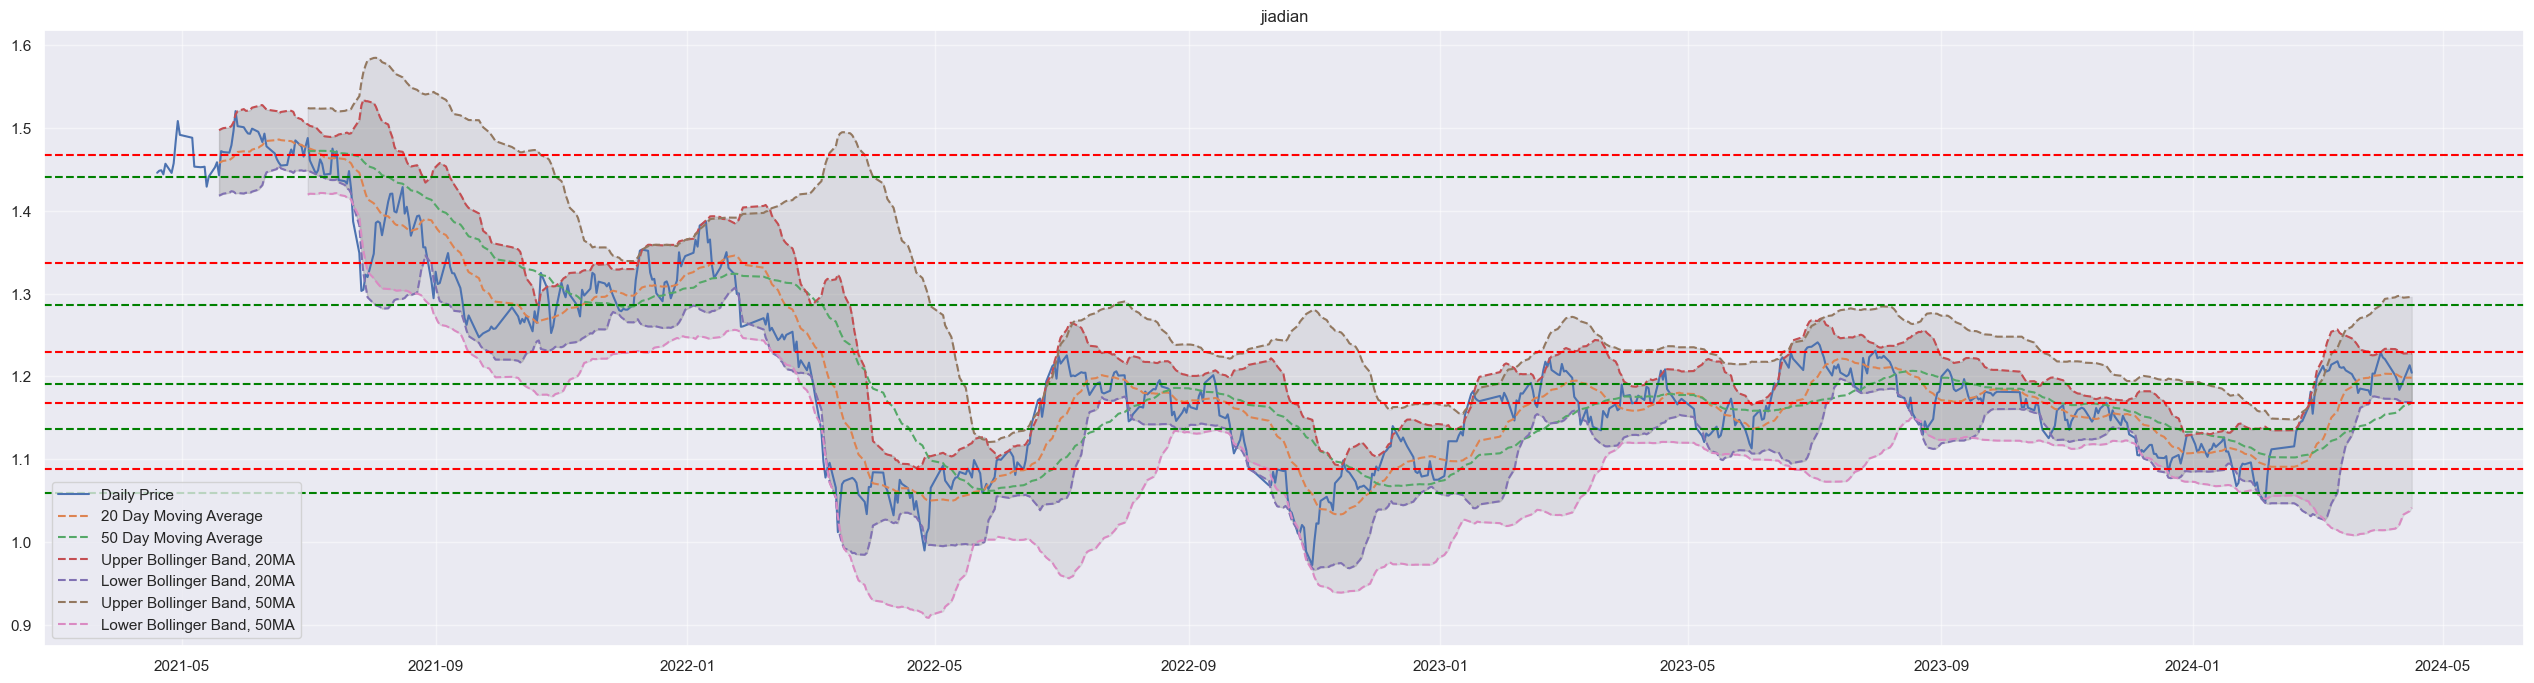

In [25]:
# Target sell: 1.23
# try buy 1.17
# 1.05 solid buy
print(df_fund["name"].unique().tolist()[11])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[11]])

quanzhiyiyao
2024-04-17
* previous stock price closing 0.74
[[0.77502353]
 [0.86467674]
 [0.94571282]
 [1.00696154]
 [1.16704138]
 [1.31692941]]
[[0.79161667]
 [0.87953333]
 [0.96177209]
 [1.02715641]
 [1.18994667]
 [1.35554706]]
Latest 20 Day MA: 0.770555
Latest Lower Bollinger Band, 20MA: 0.7339003399243323
Latest Higher Bollinger Band, 20MA: 0.8072096600756676
Latest 50 Day MA: 0.7732640000000001
Latest Lower Bollinger Band, 50MA: 0.7068925045507137
Latest Higher Bollinger Band, 50MA: 0.8396354954492864


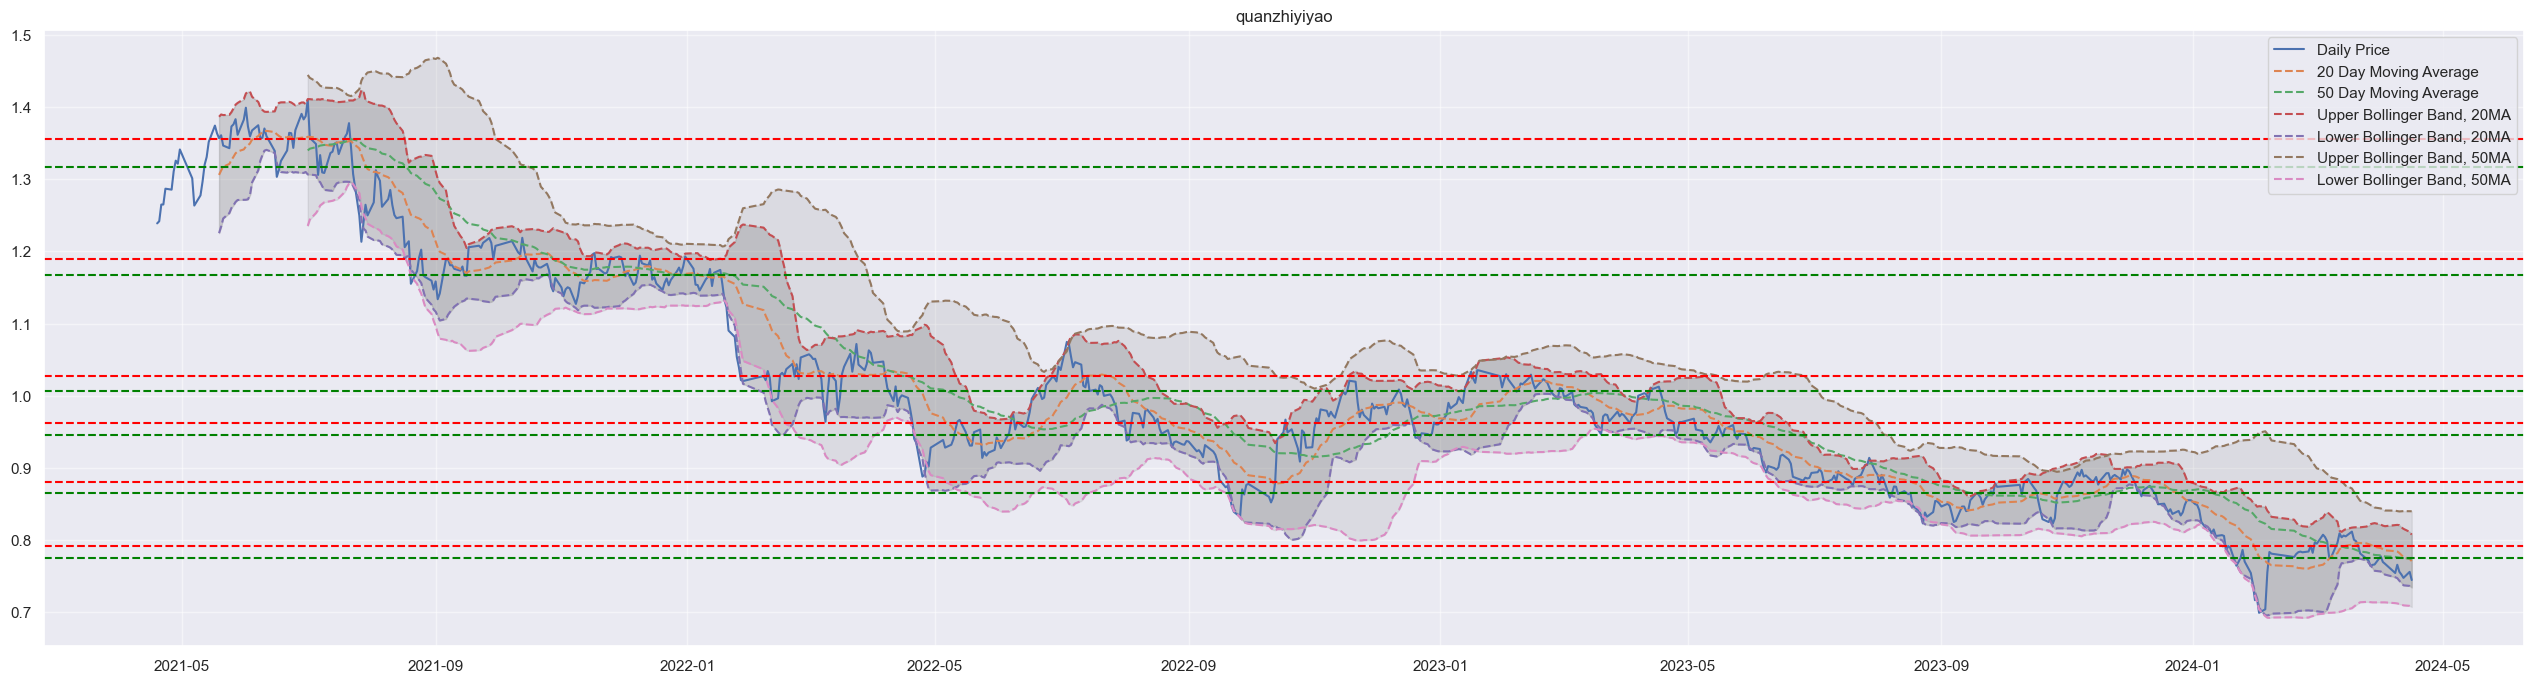

In [26]:
# buy 0.74
# try sell 20 MA 0.784
print(df_fund["name"].unique().tolist()[15])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[15]])

chuangxinyao
2024-04-17
* previous stock price closing 0.77
[[0.81054876]
 [0.93329916]
 [1.02462388]
 [1.09714237]
 [1.18246245]
 [1.38989861]
 [1.49715582]]
[[0.83577253]
 [0.96522724]
 [1.07858476]
 [1.19106683]
 [1.38201327]
 [1.48169443]
 [1.63531505]]
Latest 20 Day MA: 0.8153501035136937
Latest Lower Bollinger Band, 20MA: 0.763854154876016
Latest Higher Bollinger Band, 20MA: 0.8668460521513714
Latest 50 Day MA: 0.8151006773170184
Latest Lower Bollinger Band, 50MA: 0.7297978855749023
Latest Higher Bollinger Band, 50MA: 0.9004034690591345


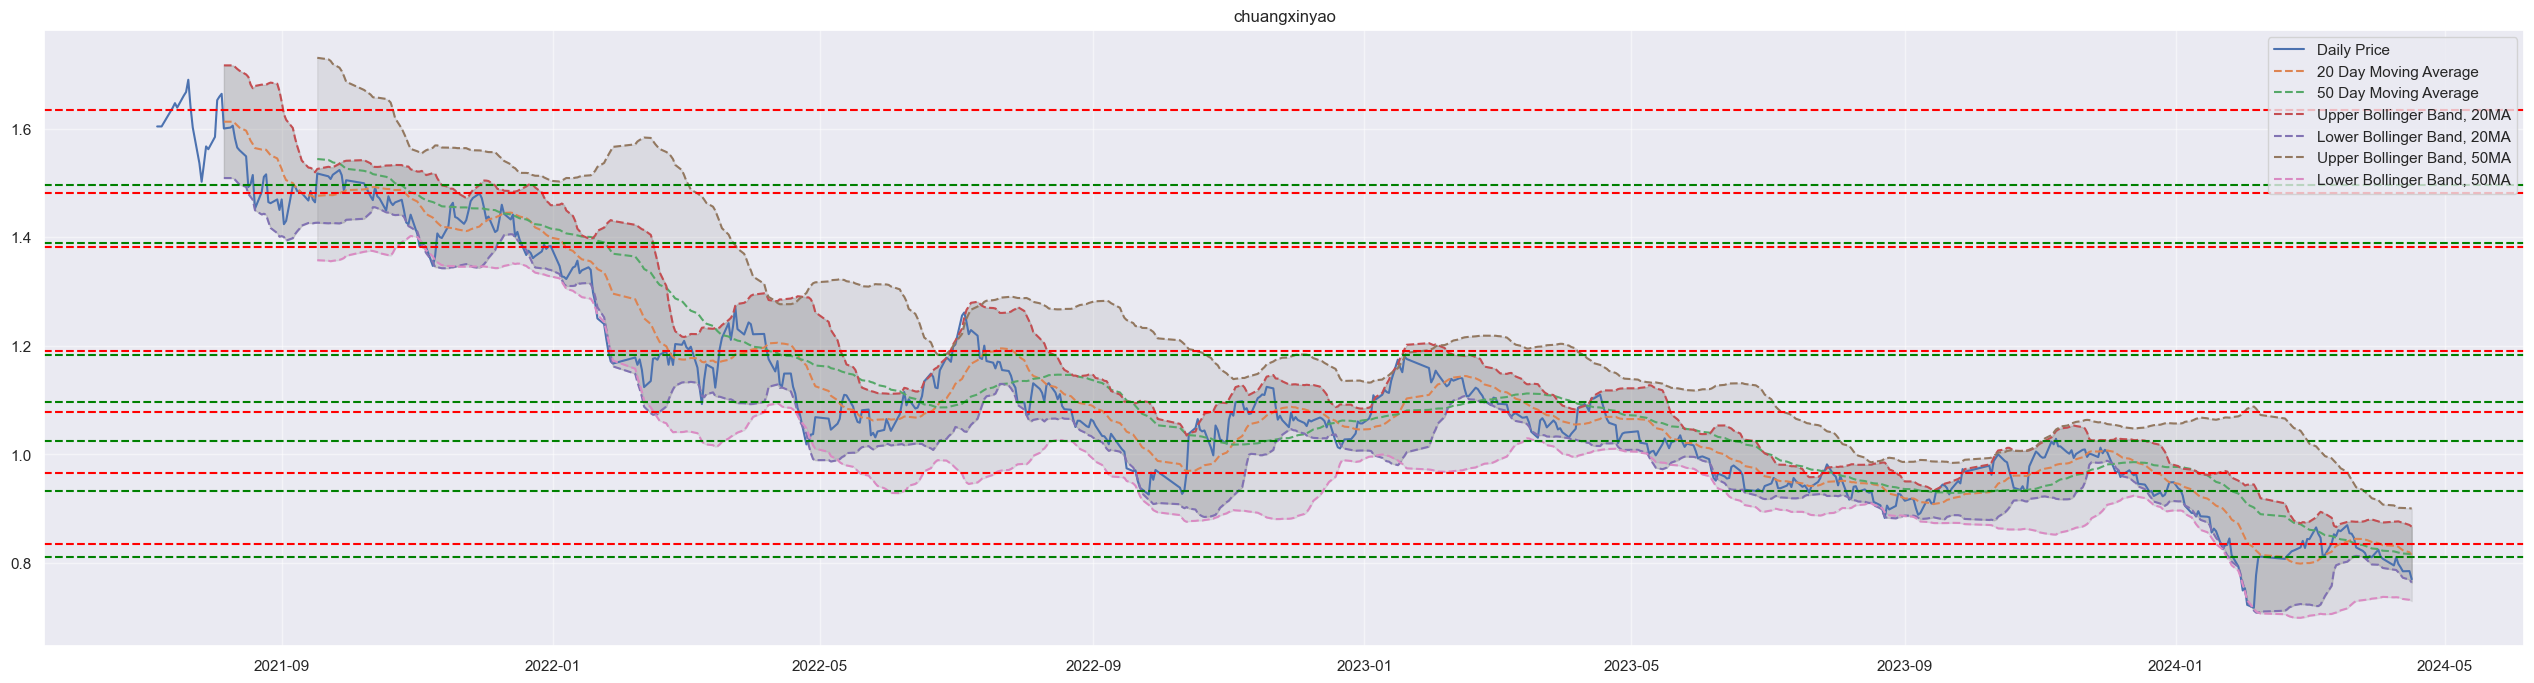

In [27]:
# try buy at Lower Bollinger Band: 0.782
# try sell at 20 MA: 0.832

print(df_fund["name"].unique().tolist()[16])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[16]])

zhongyao
2024-04-17
* previous stock price closing 0.87
[[0.81697994]
 [0.89951829]
 [0.98620801]]
[[0.83977624]
 [0.92499187]
 [1.01366523]]
Latest 20 Day MA: 0.8788221865461683
Latest Lower Bollinger Band, 20MA: 0.8588466679803706
Latest Higher Bollinger Band, 20MA: 0.898797705111966
Latest 50 Day MA: 0.8672655043860504
Latest Lower Bollinger Band, 50MA: 0.7972807179526047
Latest Higher Bollinger Band, 50MA: 0.9372502908194962


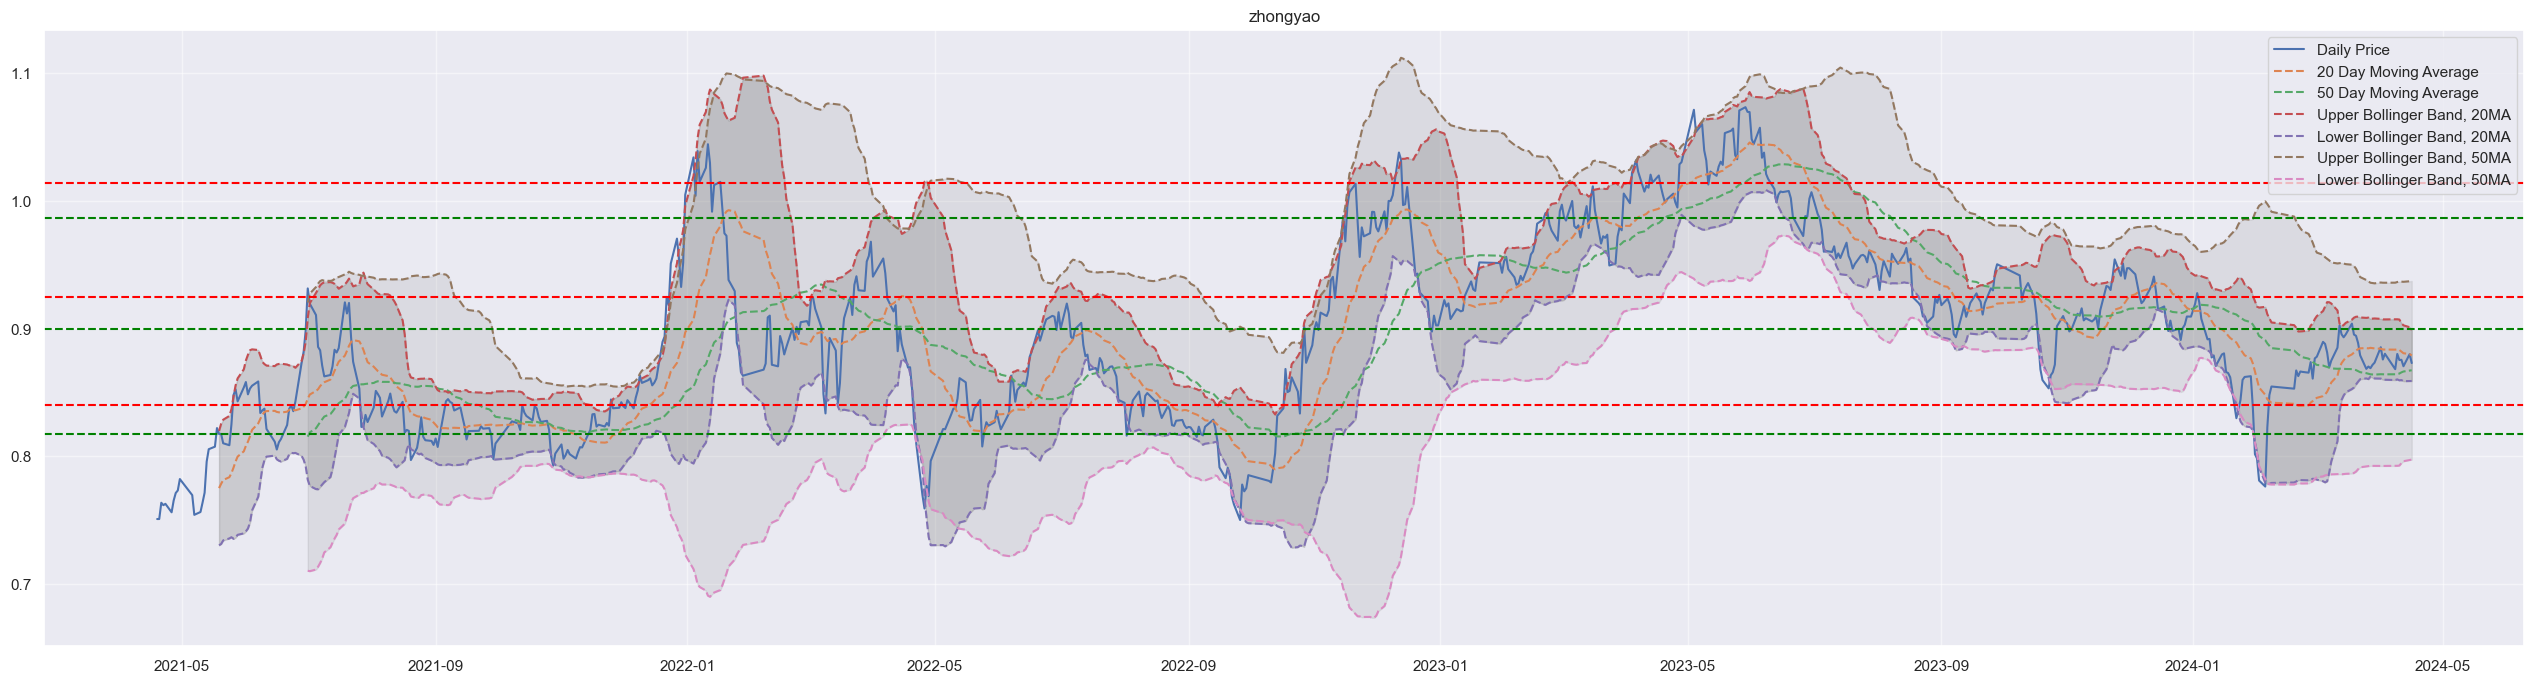

In [28]:
# Try sell at Higher Bollinger Band 0.907
# Try buy at Lower Bollinger Band 0.859
# 20MA: 0.8834
print(df_fund["name"].unique().tolist()[17])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[17]])

chuanmei
2024-04-17
* previous stock price closing 0.7
[[0.60020588]
 [0.70287679]
 [0.79897455]
 [0.89110526]]
[[0.61396458]
 [0.71771852]
 [0.81587213]
 [0.93233889]]
Latest 20 Day MA: 0.755175
Latest Lower Bollinger Band, 20MA: 0.6918190340531856
Latest Higher Bollinger Band, 20MA: 0.8185309659468145
Latest 50 Day MA: 0.72761
Latest Lower Bollinger Band, 50MA: 0.6072551754144495
Latest Higher Bollinger Band, 50MA: 0.8479648245855504


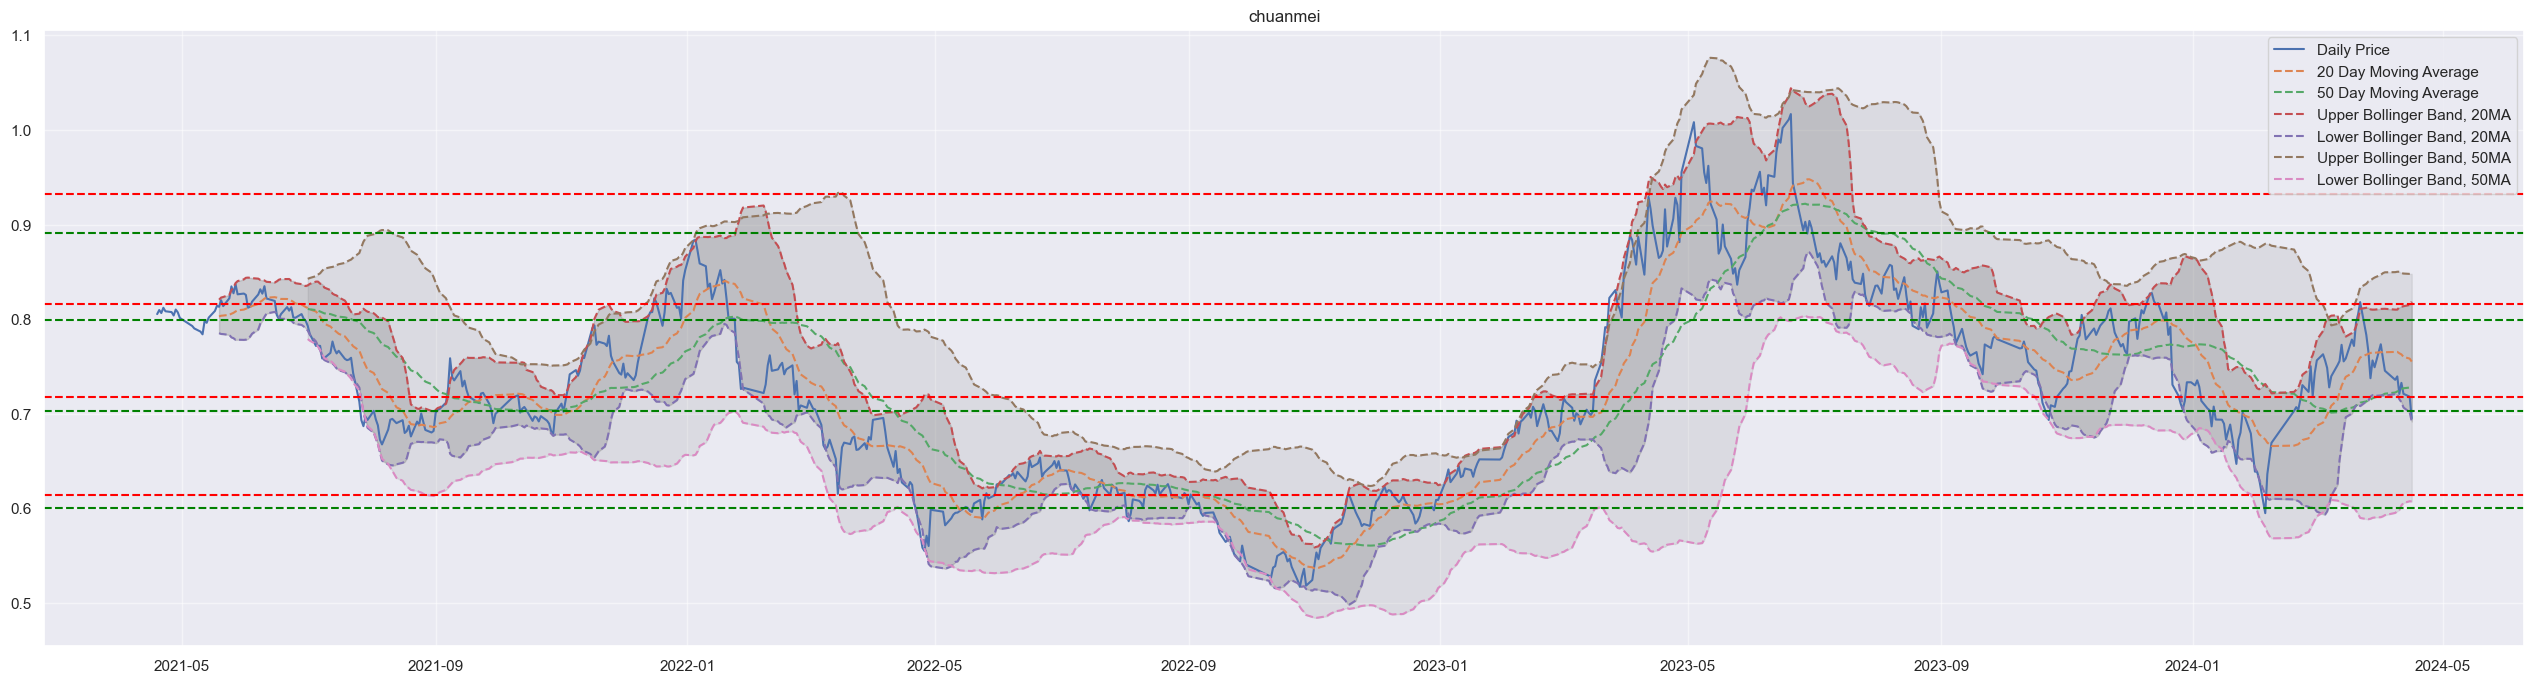

In [29]:
# sell 0.81, buy 0.71; solid buy 0.6
print(df_fund["name"].unique().tolist()[22])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[22]])

yousejinshu
2024-04-17
* previous stock price closing 0.75
[[0.67598857]
 [0.76574   ]
 [0.85813953]
 [0.94977692]]
[[0.68424375]
 [0.76406042]
 [0.84614444]
 [0.91819615]
 [1.07173333]]
Latest 20 Day MA: 0.739085
Latest Lower Bollinger Band, 20MA: 0.6732587126577564
Latest Higher Bollinger Band, 20MA: 0.8049112873422436
Latest 50 Day MA: 0.681034
Latest Lower Bollinger Band, 50MA: 0.5324992036060353
Latest Higher Bollinger Band, 50MA: 0.8295687963939647


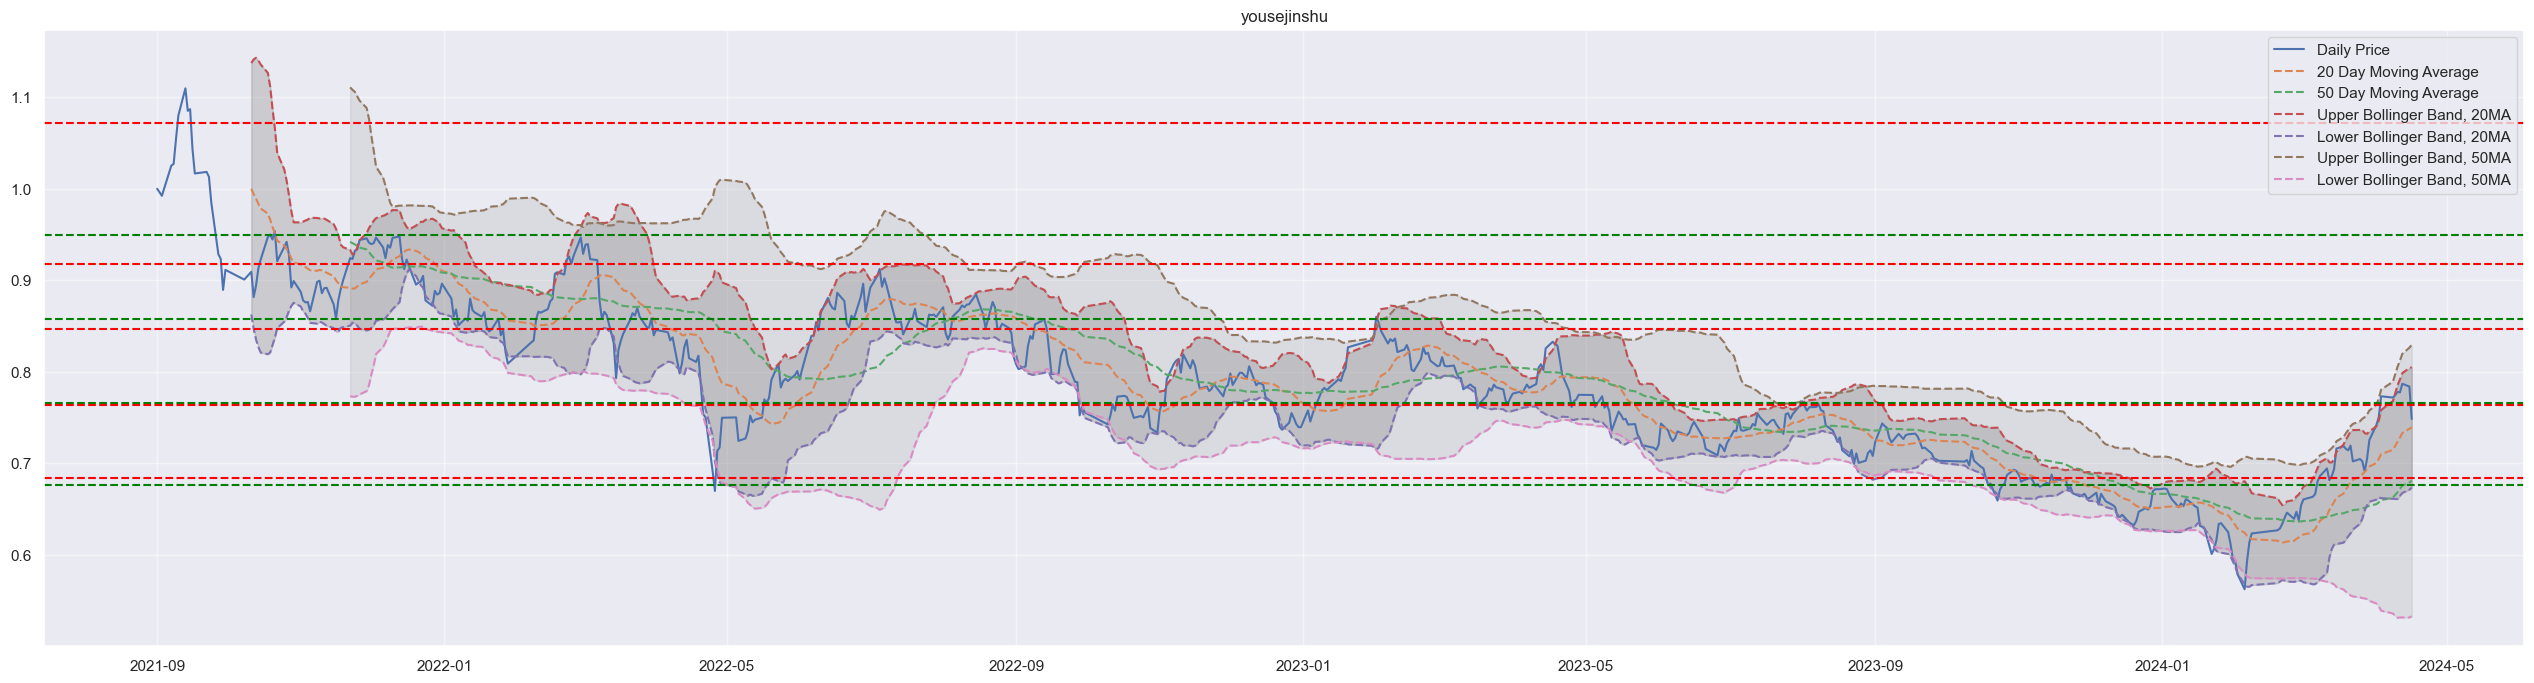

In [30]:
print(df_fund["name"].unique().tolist()[12])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[12]])

ziyuan
2024-04-17
* previous stock price closing 0.75
[[0.67598857]
 [0.76574   ]
 [0.85813953]
 [0.94977692]]
[[0.68424375]
 [0.76406042]
 [0.84614444]
 [0.91819615]
 [1.07173333]]
Latest 20 Day MA: 0.739085
Latest Lower Bollinger Band, 20MA: 0.6732587126577564
Latest Higher Bollinger Band, 20MA: 0.8049112873422436
Latest 50 Day MA: 0.681034
Latest Lower Bollinger Band, 50MA: 0.5324992036060353
Latest Higher Bollinger Band, 50MA: 0.8295687963939647


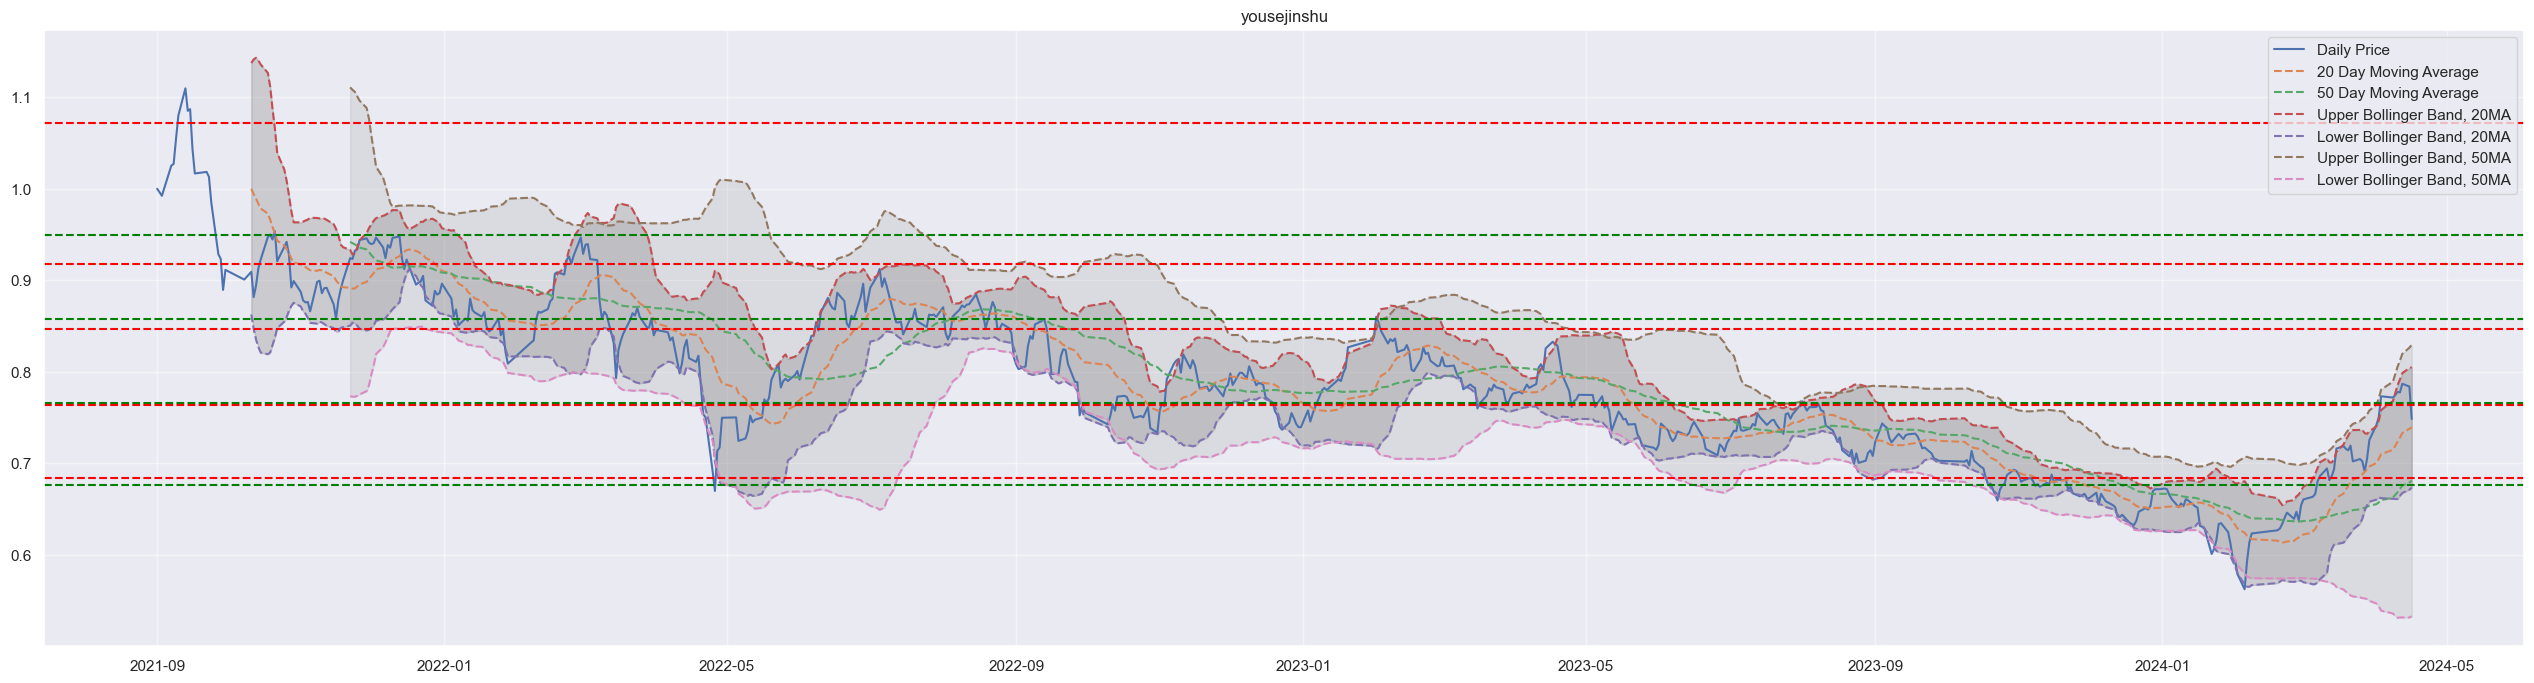

In [31]:
# sell 1.19; solid buy 1.1
print(df_fund["name"].unique().tolist()[13])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[12]])

beizheng 50
2024-04-17
* previous stock price closing 0.84
[[0.8545    ]
 [0.96636571]
 [1.05413846]]
[[0.875905  ]
 [0.98022857]
 [1.08254375]]
Latest 20 Day MA: 0.9076599999999999
Latest Lower Bollinger Band, 20MA: 0.8431294229963762
Latest Higher Bollinger Band, 20MA: 0.9721905770036237
Latest 50 Day MA: 0.919588
Latest Lower Bollinger Band, 50MA: 0.8166004259526325
Latest Higher Bollinger Band, 50MA: 1.0225755740473674


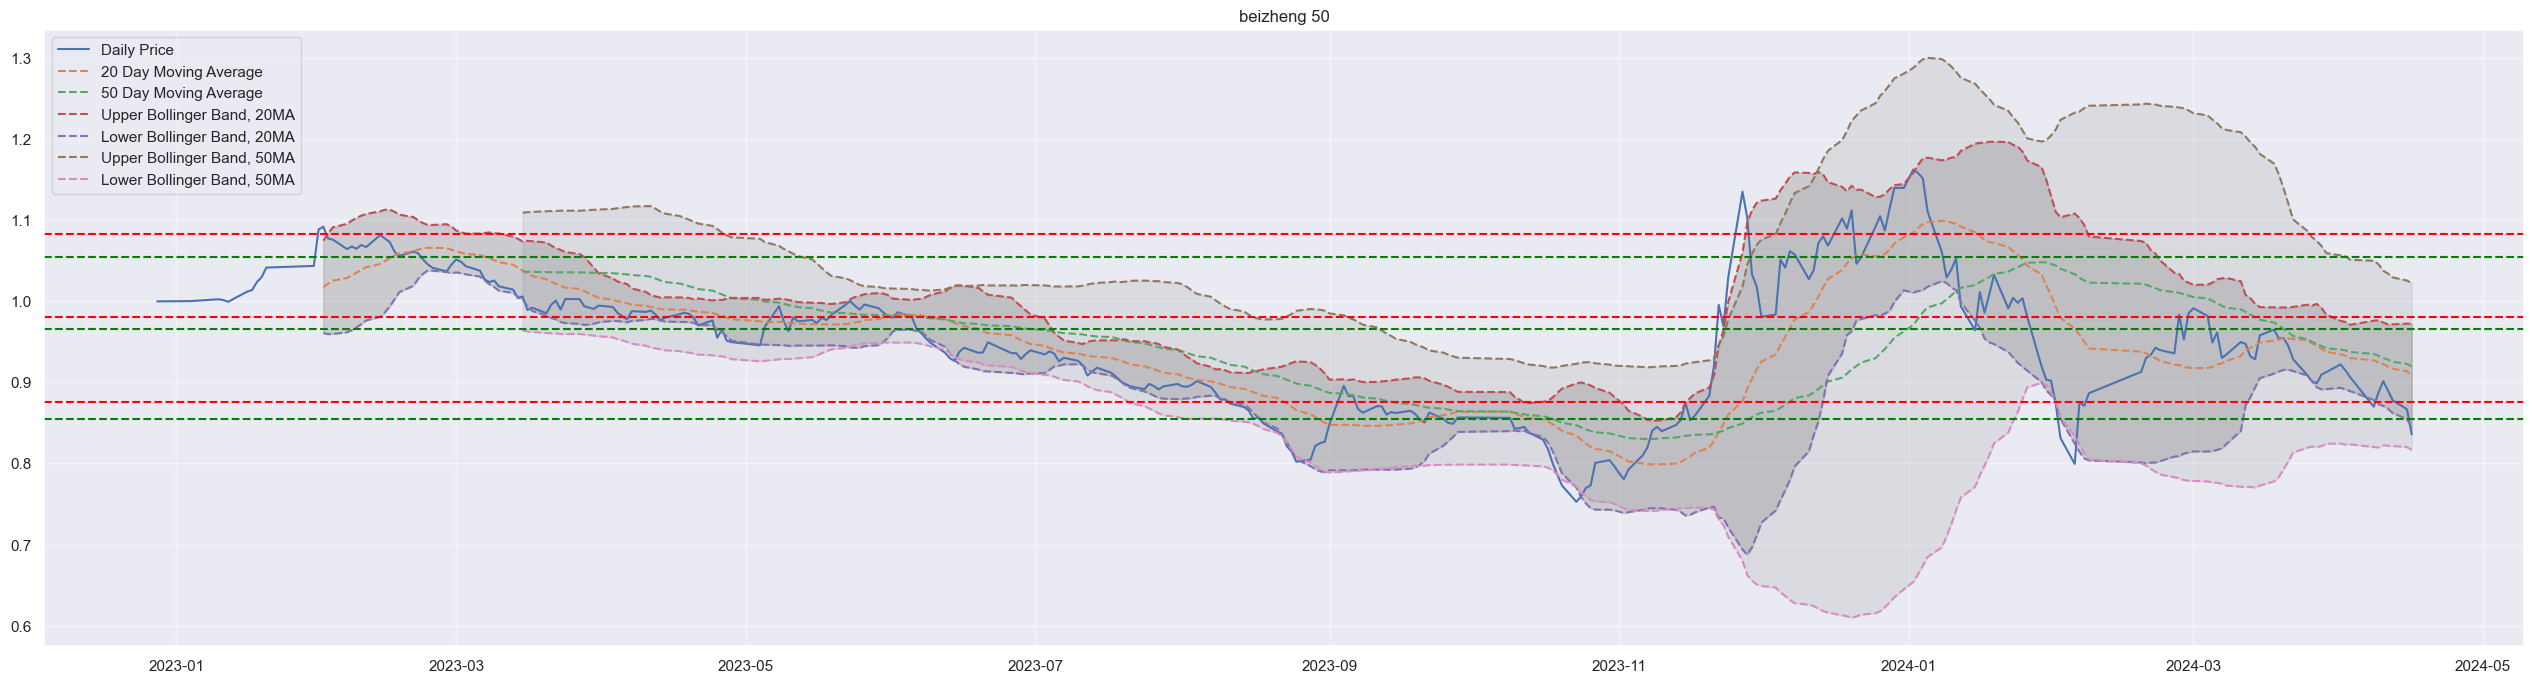

In [32]:
# Try 0.873- buy
# sell 20MA 0.92
print(df_fund["name"].unique().tolist()[20])
stock_bollinger_move(df_fund[df_fund["name"]==df_fund["name"].unique().tolist()[20]])

In [33]:
def calculate_investment_return(stock_prices, purchase_interval, investment_amount, start_date, end_date):
    # Filter stock prices between start and end date
    stock_prices = stock_prices[stock_prices['date'].between(start_date,end_date)]
    

    # Initialize variables
    total_investment = 0
    num_shares = 0
    daily_investment_value = list()
    daily_investment_amt = list()    
    last_purchase_date = None

    # Iterate over stock prices
    for idx, row in stock_prices.iterrows():
        # Check if it's time to make a purchase
        if last_purchase_date is None or (row['date'] - last_purchase_date).days >= purchase_interval:
            # Calculate number of shares to purchase
            num_shares += investment_amount / row['price']
            total_investment += investment_amount      
            last_purchase_date = row['date']
        else:
            num_shares += 0
            total_investment += 0
        
        # Calculate daily investment value
        daily_investment_value.append(num_shares * row['price'])
        daily_investment_amt.append(total_investment)

    df_strategy = stock_prices.copy()
    df_strategy['investment_value'] = daily_investment_value
    df_strategy['investment_amt_sofar'] = daily_investment_amt
    df_strategy['revenue'] = df_strategy['investment_value'] - df_strategy['investment_amt_sofar']
    df_strategy['revenue%'] = df_strategy['revenue'] / df_strategy['investment_amt_sofar']
    return df_strategy

### 定投

In [34]:
dict_autogood_2021 = dict()
for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['price'] = df_stock['NAV-Cum']
    else:
        df_stock['price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2021-01-01'):
#         print("History too short, skip")
        pass
    else:        
        stock_strategy =  calculate_investment_return(df_stock[['date','price']],
                                                      purchase_interval=7, 
                                                      investment_amount=500, 
                                                      start_date='2021-01-01', 
                                                      end_date=datetime.today().strftime('%Y-%m-%d'))
#         print(stock_strategy['revenue%'].min())
#         print(stock_strategy.iloc[-1]['revenue%'])
        if stock_strategy.iloc[-1]['revenue%'] > 0:
            dict_autogood_2021[e] = stock_strategy.iloc[-1]['revenue%']
dict_autogood_2021

{'tongxinshebei': 0.1208157308746467,
 'honglidibo': 0.25828319578648495,
 'hongli': 0.13947887495304412,
 'huangjinchanye': 0.3544670945652636}

In [35]:
dict_autogood_2022 = dict()
for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['price'] = df_stock['NAV-Cum']
    else:
        df_stock['price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2022-01-01'):
#         print("History too short, skip")
        pass
    else:
        stock_strategy =  calculate_investment_return(df_stock[['date','NAV']].rename(columns={'NAV':'price'}),
                                                      purchase_interval=7, 
                                                      investment_amount=500, 
                                                      start_date='2022-01-01', 
                                                      end_date=datetime.today().strftime('%Y-%m-%d'))
#         print(stock_strategy['revenue%'].min())
#         print(stock_strategy.iloc[-1]['revenue%'])
        if stock_strategy.iloc[-1]['revenue%'] > 0:
            dict_autogood_2022[e] = stock_strategy.iloc[-1]['revenue%']
dict_autogood_2022

{'jiadian': 0.04879226391674162,
 'ziyuan': 0.1009888941034664,
 'tongxinshebei': 0.13095754835311796,
 'honglidibo': 0.18102489905703195,
 'hongli': 0.06513292415592215,
 'huangjinchanye': 0.3028129448424078}

### 网格

In [36]:
import sys
sys.path.append('../src') 
from utils import stock_trading_strategy
dict_gridgood_2021 = dict()

for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['daily_price'] = df_stock['NAV-Cum']
    else:
        df_stock['daily_price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2021-01-01'):
#         print("History too short, skip")
        pass
    else:
        result =  stock_trading_strategy(df_stock[['date','daily_price']],
                                         start_date='2021-01-01',
                                         end_date=datetime.today().strftime('%Y-%m-%d'))
#         print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)
        if (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000 > 0:
            dict_gridgood_2021[e] = (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000
dict_gridgood_2021

{'zhongzheng 500': 449.204966691148,
 '500dibo': 223.6063968227154,
 'bandaoti - zhongzheng': 287.30599863525094,
 'rengongzhineng': 787.0186413909651,
 'jiadian': 551.4579662644901,
 'tongxinshebei': 1733.712887020938,
 'zhongyao': 118.8025291577942,
 'honglidibo': 57.86035462797918,
 'hongli': 51.475568456700785,
 'huangjinchanye': 233.94941718200607,
 'chuanmei': 1487.4556370144783}

In [37]:
import sys
sys.path.append('../src') 
from utils import stock_trading_strategy
dict_gridgood_2022 = dict()

for e in df_fund["name"].unique().tolist():
#     print(e)
    df_stock = df_fund[df_fund["name"]==e].sort_values(by='date').reset_index()
    if e == 'hongli':
        df_stock['daily_price'] = df_stock['NAV-Cum']
    else:
        df_stock['daily_price'] = df_stock['NAV']
    if df_stock['date'].min() > pd.to_datetime('2022-01-01'):
#         print("History too short, skip")
        pass
    else:
        result =  stock_trading_strategy(df_stock[['date','daily_price']],
                                         start_date='2022-01-01',
                                         end_date=datetime.today().strftime('%Y-%m-%d'))
#         print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)
        if (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000 > 0:
            dict_gridgood_2022[e] = (result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000
dict_gridgood_2022

{'500dibo': 400.80386902134524,
 'zhinengqiche': 154.79755478443985,
 'rengongzhineng': 104.91095610561752,
 'jiadian': 450.09941159704977,
 'yousejinshu': 779.5687645995531,
 'ziyuan': 1000.496112555511,
 'tongxinshebei': 1642.3588089633668,
 'zhongyao': 653.5335974345726,
 'honglidibo': 274.6751712833284,
 'hongli': 321.02622060894646,
 'huangjinchanye': 115.33622854761234,
 'chuanmei': 1179.6075584248829}

##### 红利低波 - 定投
创金合信 1.8 买入

易方达 = 0.07927750001695077 + 0.504527891091394*test

0.987 买入

2024-04-17
* previous stock price closing 1.93
[[1.35744138]
 [1.49157105]
 [1.56077391]
 [1.6982902 ]
 [1.82819091]]
[[1.37378846]
 [1.49860833]
 [1.56919298]
 [1.677244  ]
 [1.74588333]
 [1.86454545]]
Latest 20 Day MA: 1.859565
Latest 50 Day MA: 1.832678
Latest Lower Bollinger Band, 20MA: 1.7878579857354264
Latest Higher Bollinger Band, 20MA: 1.9312720142645734
Latest Lower Bollinger Band, 50MA: 1.7163533389852357
Latest Higher Bollinger Band, 50MA: 1.9490026610147644
Latest regression: [1.80941825]
Annual return rate: 0.14882827321012432


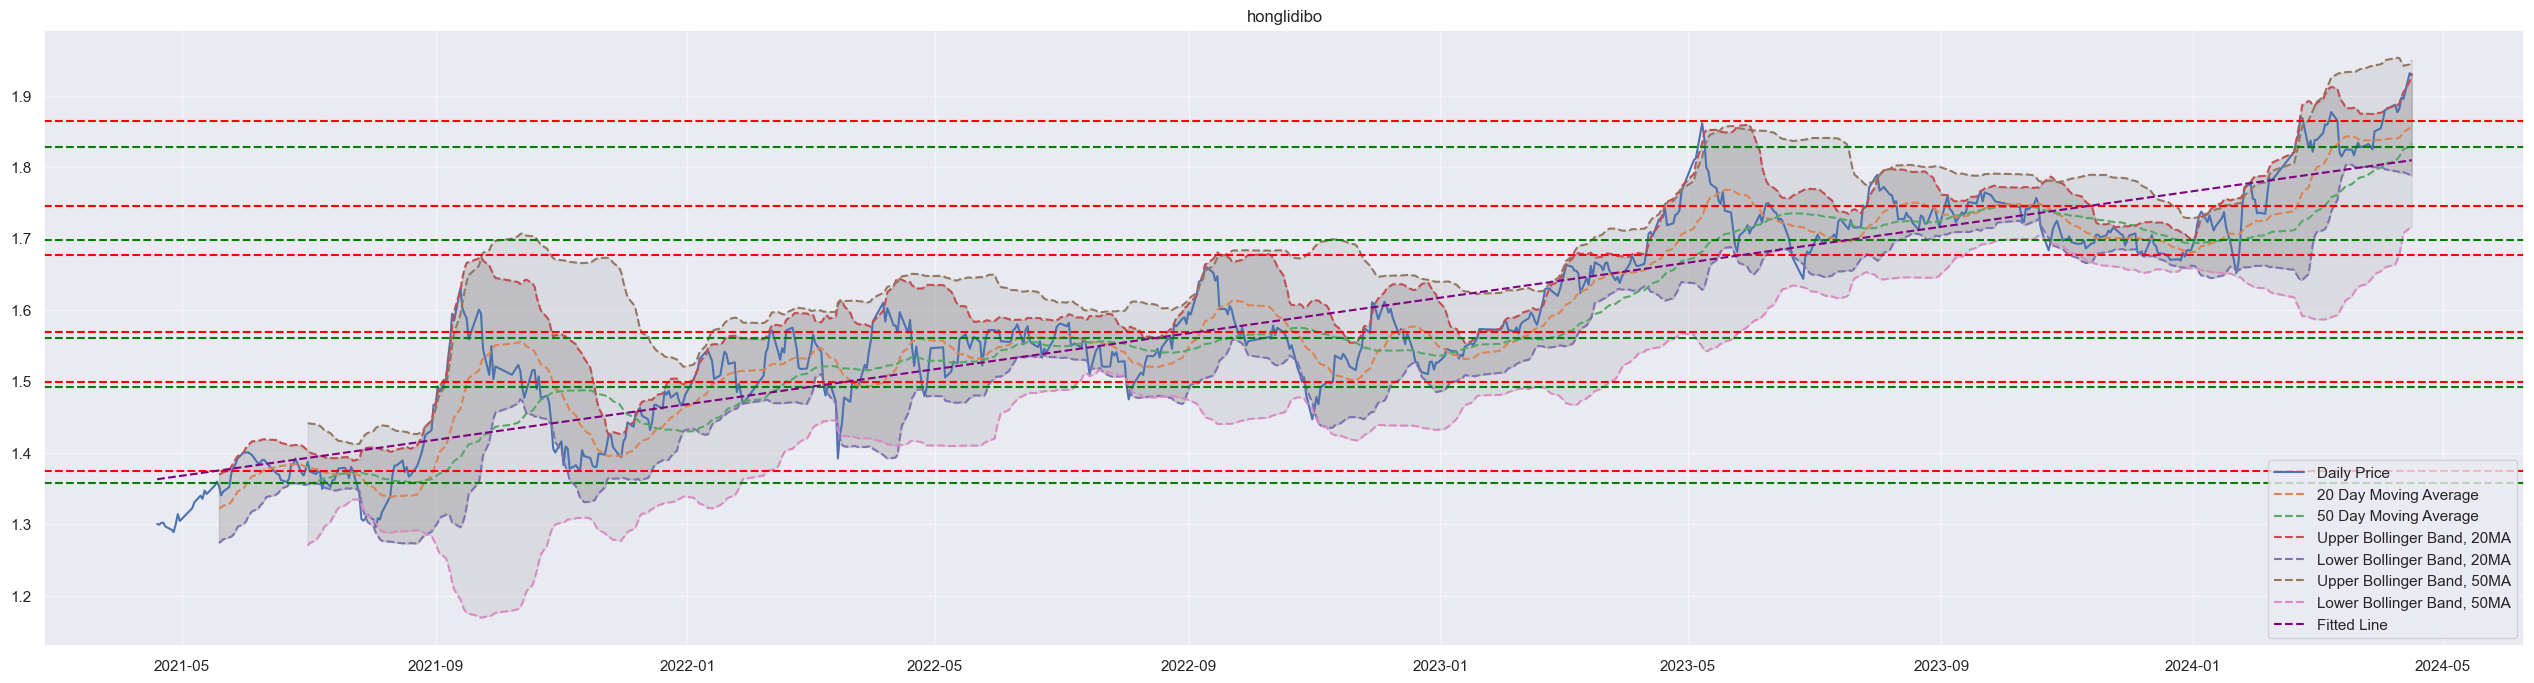

In [38]:
stock_df = df_fund[df_fund["name"]=='honglidibo']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

df['20 Day MA'] = df['NAV'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV'].rolling(window=20).std()
df['50 Day MA'] = df['NAV'].rolling(window=50).mean()
df['50 Day STD'] = df['NAV'].rolling(window=50).std()
# Calculate upper and lower bands
df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
print("Latest 50 Day MA:", df['50 Day MA'].tolist()[-1])

print("Latest Lower Bollinger Band, 20MA:", df['Lower Band - 20MA'].tolist()[-1])
print("Latest Higher Bollinger Band, 20MA:", df['Upper Band - 20MA'].tolist()[-1])
print("Latest Lower Bollinger Band, 50MA:", df['Lower Band - 50MA'].tolist()[-1])
print("Latest Higher Bollinger Band, 50MA:", df['Upper Band - 50MA'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]
print("Latest regression:", X_b.dot(theta_best)[-1])

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.11558604215459481

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV'], label='Daily Price')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')

ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='purple', label='Fitted Line')
ax.legend()
ax.grid(True)

##### 红利 - 定投

2024-04-17
* previous stock price closing 1.38
[[1.15201628]
 [1.21556316]
 [1.28939655]]
[[1.1884    ]
 [1.25746111]
 [1.32694375]]
Latest 20 Day MA: 1.35188
Latest 50 Day MA: 1.3401100000000001
Latest Lower Bollinger Band, 20MA: 1.3192518494161036
Latest Higher Bollinger Band, 20MA: 1.3845081505838963
Latest Lower Bollinger Band, 50MA: 1.266063695368409
Latest Higher Bollinger Band, 50MA: 1.4141563046315913
Annual return rate: 0.05149847906652807
Latest regression: [1.31314473]


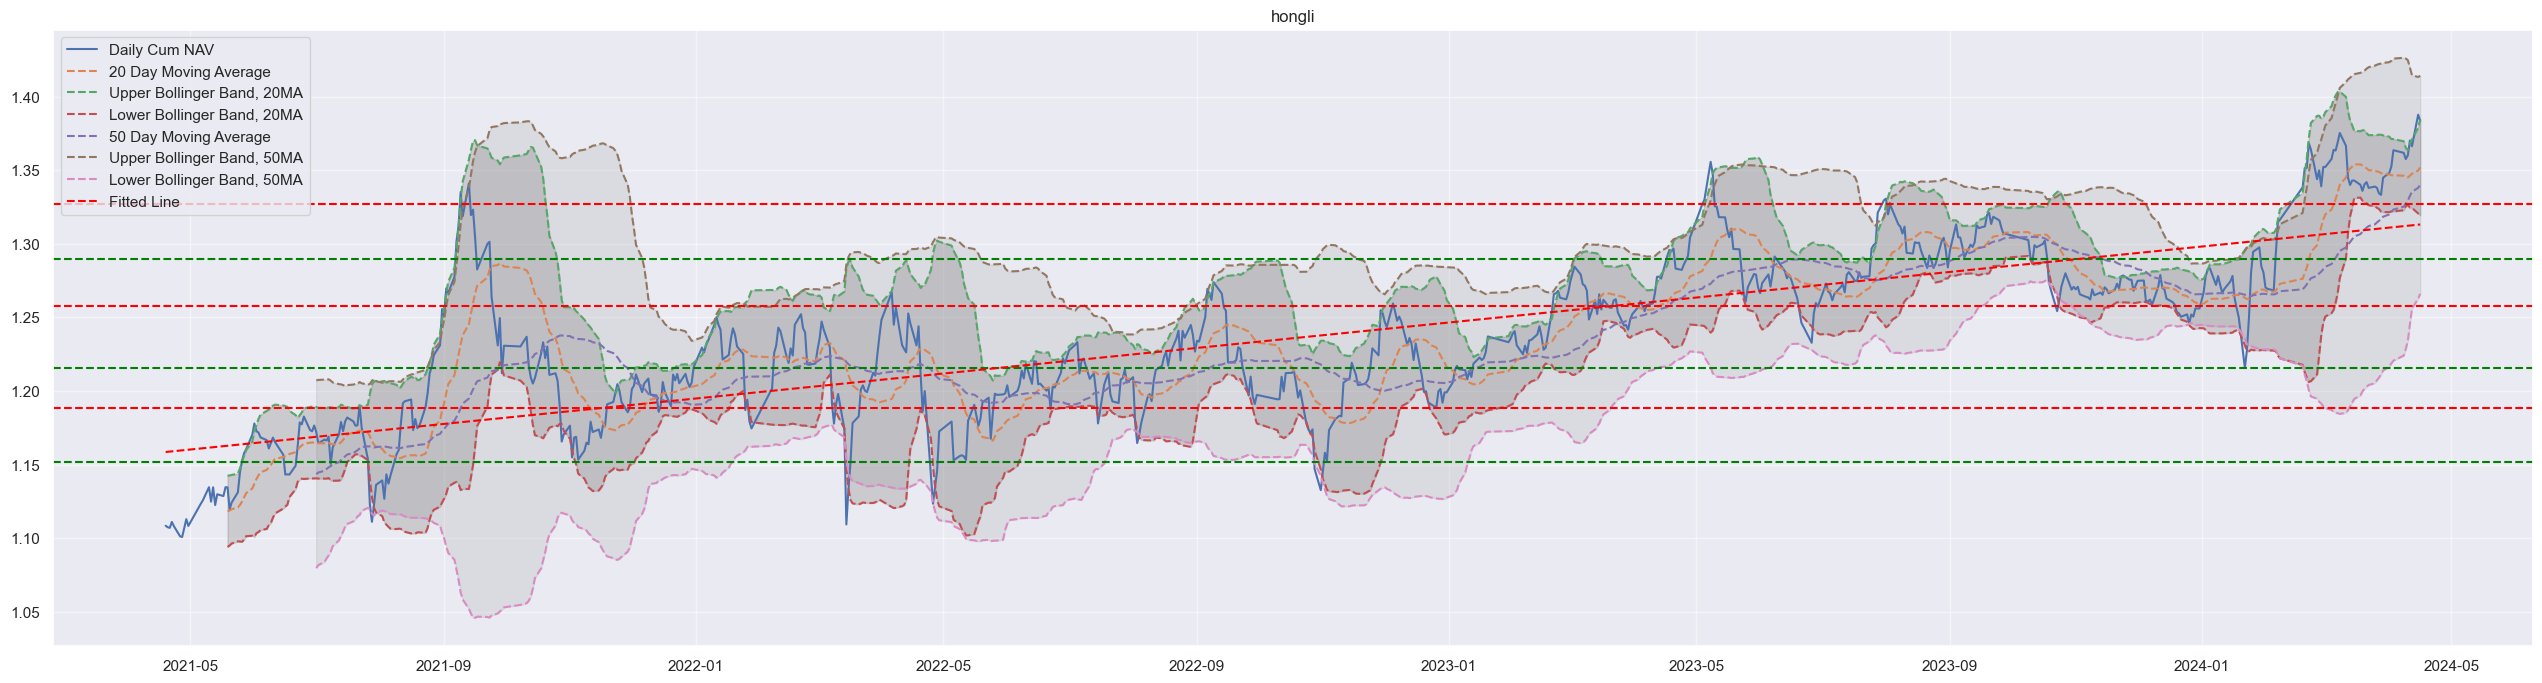

In [39]:
stock_df = df_fund[df_fund["name"]=='hongli']
start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
# start=df_fund['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV-Cum']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

# For hongli, need to use NAV-Cum
df['20 Day MA'] = df['NAV-Cum'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV-Cum'].rolling(window=20).std()
df['50 Day MA'] = df['NAV-Cum'].rolling(window=50).mean()
df['50 Day STD'] = df['NAV-Cum'].rolling(window=50).std()
    
# Calculate upper and lower bands
df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
print("Latest 50 Day MA:", df['50 Day MA'].tolist()[-1])
print("Latest Lower Bollinger Band, 20MA:", df['Lower Band - 20MA'].tolist()[-1])
print("Latest Higher Bollinger Band, 20MA:", df['Upper Band - 20MA'].tolist()[-1])
print("Latest Lower Bollinger Band, 50MA:", df['Lower Band - 50MA'].tolist()[-1])
print("Latest Higher Bollinger Band, 50MA:", df['Upper Band - 50MA'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV-Cum'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.03184651573698018
print("Latest regression:", X_b.dot(theta_best)[-1])

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV-Cum'], label='Daily Cum NAV')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')
ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='red', label='Fitted Line')
ax.legend()
ax.grid(True)

##### 黄金

2024-04-17
* previous stock price closing 1.9
[[1.27456447]
 [1.34124444]
 [1.40321633]
 [1.5265    ]
 [1.6169    ]
 [1.88485   ]]
[[1.28407424]
 [1.34448254]
 [1.40778421]
 [1.53711111]
 [1.63245667]
 [1.90355   ]]
Latest 20 Day MA: 1.80459
Latest 50 Day MA: 1.716344
Latest Lower Bollinger Band, 20MA: 1.6592076308379986
Latest Higher Bollinger Band, 20MA: 1.9499723691620012
Latest Lower Bollinger Band, 50MA: 1.4899215735398972
Latest Higher Bollinger Band, 50MA: 1.942766426460103
Annual return rate: 0.0786600188506967


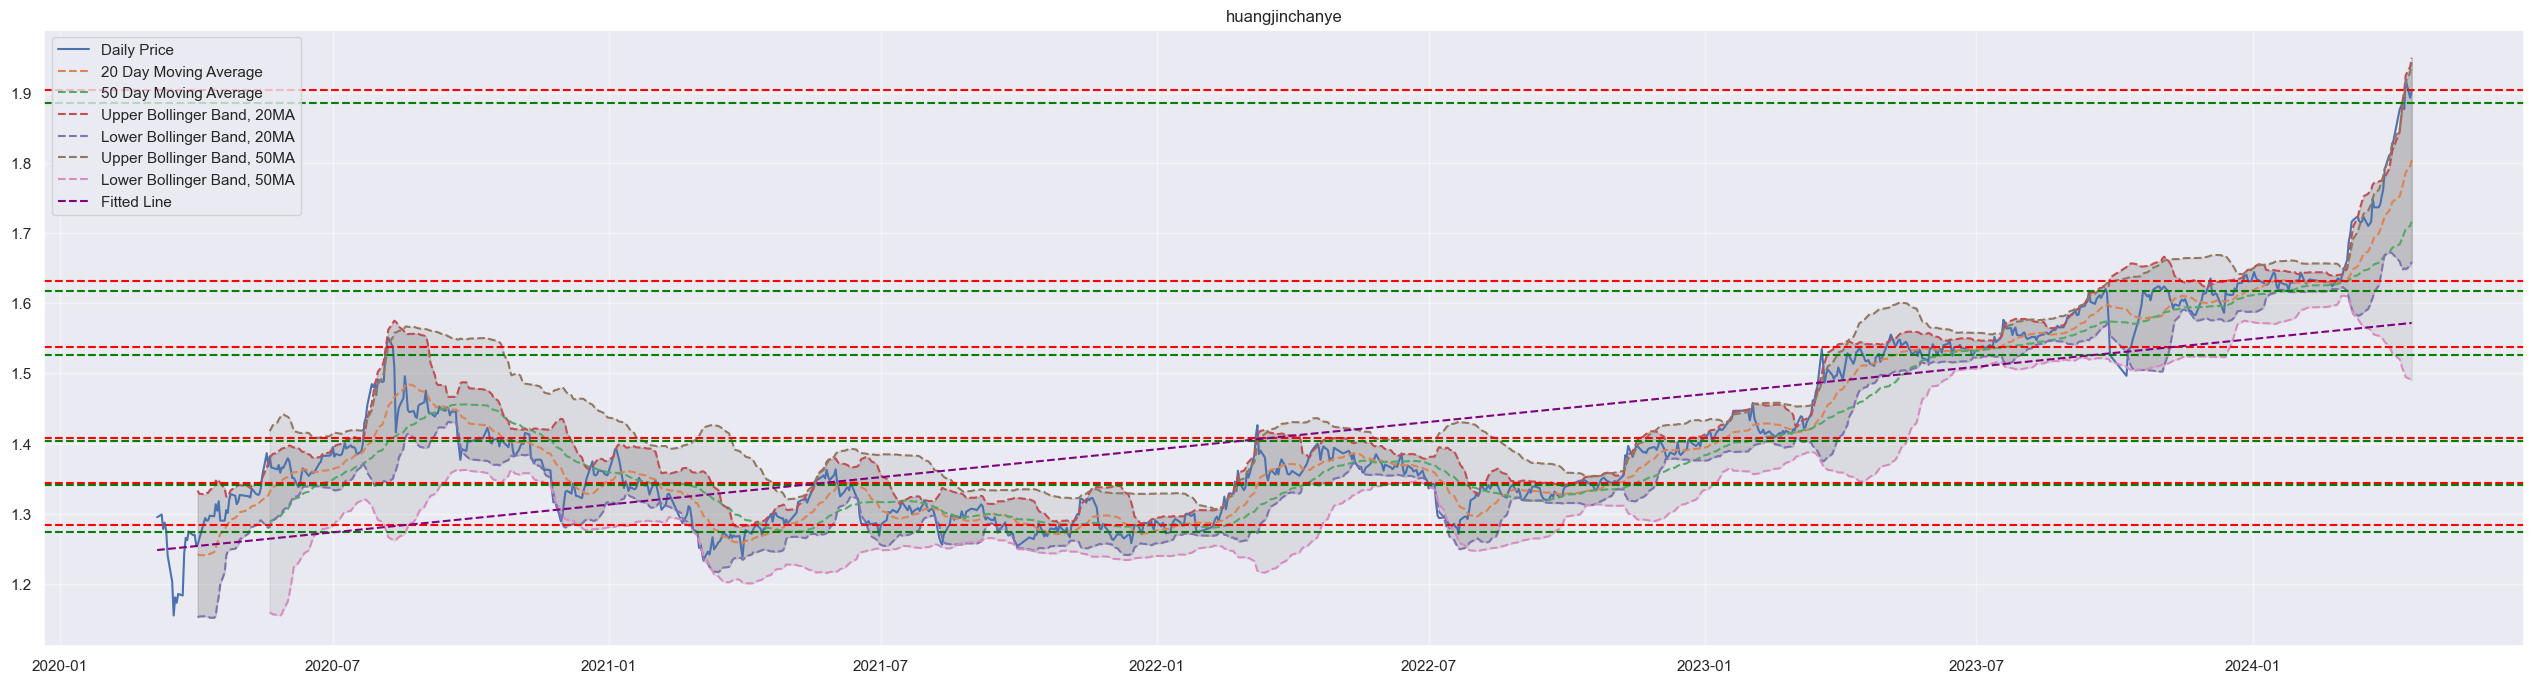

In [40]:
stock_df = df_fund[df_fund["name"]=='huangjinchanye']
# start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d')
start=stock_df['date'].min()

df = stock_df[stock_df['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
df = df.sort_values(by='date').reset_index()
df['daily_price'] = df['NAV']

print(datetime.today().strftime('%Y-%m-%d'))
print('* previous stock price closing', round(df.iloc[-1]['daily_price'],2))

# Support and Resistance
df = identify_weak_support_resistance(df)
low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"daily_price"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"daily_price"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

df['20 Day MA'] = df['NAV'].rolling(window=20).mean()
df['20 Day STD'] = df['NAV'].rolling(window=20).std()
df['50 Day MA'] = df['NAV'].rolling(window=50).mean()
df['50 Day STD'] = df['NAV'].rolling(window=50).std()
# Calculate upper and lower bands
df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
print("Latest 50 Day MA:", df['50 Day MA'].tolist()[-1])

print("Latest Lower Bollinger Band, 20MA:", df['Lower Band - 20MA'].tolist()[-1])
print("Latest Higher Bollinger Band, 20MA:", df['Upper Band - 20MA'].tolist()[-1])
print("Latest Lower Bollinger Band, 50MA:", df['Lower Band - 50MA'].tolist()[-1])
print("Latest Higher Bollinger Band, 50MA:", df['Upper Band - 50MA'].tolist()[-1])

fig, ax = plt.subplots(figsize=(32,8))

# fit a trend line
df['date_numeric'] = pd.to_numeric(df['date'])
X = df['date_numeric'].values.reshape(-1, 1)  # Feature matrix (date)
y = df['NAV'].values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print("Annual return rate:", (X_b.dot(theta_best)[-1]-X_b.dot(theta_best)[0])[0]/((datetime.today()-pd.to_datetime(start)).days/365.2425))
# All time: Annual return rate: 0.07699482486915966

ax.grid(True, alpha=0.5)
ax.set_title(stock_df['name'].unique()[0])
ax.plot(df['date'], df['NAV'], label='Daily Price')
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')

ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
ax.plot(df['date'], X_b.dot(theta_best), ls='--', color='purple', label='Fitted Line')
ax.legend()
ax.grid(True)

### Conclusion:
* 红利低波\红利 定投
* 通信设备、资源、传媒 网格
* 黄金产业 allin

In [41]:
def test_grid(stock_list, th1, th2, m, start_date='2021-01-01'):
    today_date = datetime.today().strftime('%Y-%m-%d')
    initial_cash = 10000
    investment = 1000
    list_stock = []
    list_profit = []
    list_max_loss = []
    list_number_actions = []
    list_minimal_cash_reserve = []
    list_price_change = []
#     for stock_name in dict_gridgood_2021:
    for stock_name in stock_list:
        stock_df = df_fund[df_fund["name"]==stock_name].sort_values(by='date').reset_index()[['date','NAV']].rename(columns={'NAV':'daily_price'})
        result = stock_trading_strategy(stock_df, start_date, today_date, initial_cash, investment, th1, th2, m)
        profit = ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-initial_cash)
        underlying_stock_price_change = (result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']
        max_loss = (result['total_stock_value']+result['total_cash']).min() - initial_cash
        number_actions = result[result['action'].isin(['Purchase','Sell'])].shape[0]
        minimal_cash_reserve = result['total_cash'].min()
        list_stock.append(stock_name)
        list_profit.append(profit)
        list_price_change.append(underlying_stock_price_change)
        list_max_loss.append(max_loss)
        list_minimal_cash_reserve.append(minimal_cash_reserve)
        list_number_actions.append(number_actions)

    df_all_stock = pd.DataFrame(
        {
            'stock_name': list_stock,
            'start_date': [start_date]*len(list_stock),
            'end_date': [today_date]*len(list_stock),
            'initial_cash': [initial_cash]*len(list_stock),
            'investment': [investment]*len(list_stock),
            'buy_threshold': [th1]*len(list_stock),
            'sell_threshold': [th2]*len(list_stock),
            'multiplier': [m]*len(list_stock),
            'profit': list_profit,
            'underlying_stock_price_change': list_price_change,
            'max_loss': list_max_loss,
            'minimal_cash_reserve': list_minimal_cash_reserve,
            'number_actions': list_number_actions
        }
    )
    print('Numbers of stock tested:', len(list_stock))
    print(df_all_stock.shape)
    return df_all_stock

In [42]:
strategy_dfs_2021 = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_grid(list(dict_gridgood_2021.keys()), th1, th2, m)
            strategy_dfs_2021.append(df_strategy)

Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
Numbers of stock tested: 11
(11, 13)
N

In [43]:
good_dfs_2021 = []
for df in strategy_dfs_2021:
    good_dfs_2021.append(df[(df['profit']>=1000)&(df['max_loss']>=-1000)])
good_df_2021 = pd.concat(good_dfs_2021)
print(good_df_2021.shape)
good_df_2021.head()

(37, 13)


stock_name  start_date    end_date  initial_cash  investment  \
5  tongxinshebei  2021-01-01  2024-04-17         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-17         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-17         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-17         10000        1000   
5  tongxinshebei  2021-01-01  2024-04-17         10000        1000   

   buy_threshold  sell_threshold  multiplier       profit  \
5           0.05            0.05        1.00  1733.712887   
5           0.05            0.05        1.05  2227.771519   
5           0.05            0.10        1.00  1781.856635   
5           0.05            0.10        1.05  2178.923078   
5           0.05            0.15        1.00  2460.234380   

   underlying_stock_price_change    max_loss  minimal_cash_reserve  \
5                       0.047679 -607.268649           4393.187923   
5                       0.047679 -707.911907           3288.230753   
5                       0.047679 -713.175903           4308.625447   
5                       0.047679 -806.701204           3248.314818   
5                       0.047679 -732.457151           4321.106070   

   number_actions  
5              58  
5              58  
5              32  
5              32  
5              30

In [44]:
good_df_2021[["stock_name", "underlying_stock_price_change"]].drop_duplicates()

stock_name  underlying_stock_price_change
5   tongxinshebei                       0.047679
10       chuanmei                      -0.194789

In [45]:
good_df_2021[
  (good_df_2021['max_loss']>=-1000)
  &
  (good_df_2021['profit']>1000)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
5   tongxinshebei           0.05            0.25        1.05  3214.260654   
5   tongxinshebei           0.05            0.15        1.05  2915.004478   
5   tongxinshebei           0.05            0.25        1.00  2678.990236   
5   tongxinshebei           0.05            0.20        1.05  2626.713838   
5   tongxinshebei           0.05            0.15        1.00  2460.234380   
5   tongxinshebei           0.07            0.25        1.05  2230.668145   
5   tongxinshebei           0.05            0.05        1.05  2227.771519   
5   tongxinshebei           0.05            0.20        1.00  2197.626616   
5   tongxinshebei           0.05            0.10        1.05  2178.923078   
5   tongxinshebei           0.07            0.20        1.05  1990.667539   
5   tongxinshebei           0.07            0.30        1.05  1981.231205   
5   tongxinshebei           0.07            0.25        1.00  1949.559497   
10       chuanmei           0.07            0.10        1.05  1853.900144   
5   tongxinshebei           0.07            0.15        1.05  1822.170004   
5   tongxinshebei           0.05            0.10        1.00  1781.856635   
5   tongxinshebei           0.07            0.20        1.00  1749.638853   
5   tongxinshebei           0.07            0.30        1.00  1733.883882   
5   tongxinshebei           0.05            0.05        1.00  1733.712887   
5   tongxinshebei           0.07            0.15        1.00  1619.877015   
5   tongxinshebei           0.07            0.10        1.05  1587.892595   
10       chuanmei           0.10            0.25        1.05  1569.833320   
10       chuanmei           0.07            0.10        1.00  1526.043637   
5   tongxinshebei           0.10            0.25        1.05  1489.127724   
5   tongxinshebei           0.10            0.15        1.05  1445.697674   
5   tongxinshebei           0.10            0.30        1.05  1445.234174   
5   tongxinshebei           0.07            0.05        1.05  1434.218127   
5   tongxinshebei           0.07            0.10        1.00  1388.291122   
5   tongxinshebei           0.10            0.25        1.00  1361.851572   
10       chuanmei           0.10            0.25        1.00  1345.322117   
5   tongxinshebei           0.10            0.15        1.00  1342.860053   
5   tongxinshebei           0.10            0.30        1.00  1315.626989   
5   tongxinshebei           0.10            0.20        1.05  1304.521879   
5   tongxinshebei           0.07            0.05        1.00  1269.771545   
5   tongxinshebei           0.10            0.20        1.00  1195.085932   
10       chuanmei           0.10            0.05        1.05  1130.478975   
10       chuanmei           0.10            0.10        1.05  1061.958217   
5   tongxinshebei           0.10            0.05        1.05  1050.097019   

      max_loss  minimal_cash_reserve  
5  -845.608287           3489.345214  
5  -779.750151           3560.754553  
5  -796.928483           4251.599634  
5  -904.336064           3430.617438  
5  -732.457151           4321.106070  
5  -883.704986           4474.368750  
5  -707.911907           3288.230753  
5  -847.659744           4200.868373  
5  -806.701204           3248.314818  
5  -623.790163           4710.422899  
5  -883.704986           4474.368750  
5  -833.082154           5000.000000  
10 -982.523243           2503.959602  
5  -687.352791           4646.860272  
5  -713.175903           4308.625447  
5  -597.957919           5214.108071  
5  -833.082154           5000.000000  
5  -607.268649           4393.187923  
5  -655.611095           5156.454895  
5  -624.636441           4710.326314  
10 -982.281671           4776.395221  
10 -930.904538           3561.779904  
5  -634.118427           5689.875000  
5  -466.966262           5862.314024  
5  -634.118427           5689.875000  
5  -421.089824           4839.904854  
5  -593.840768           52

In [46]:
good_df_2021[
  (good_df_2021['max_loss']>=-1000)
  &
  (good_df_2021['profit']>1500)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

stock_name  buy_threshold  sell_threshold  multiplier       profit  \
5   tongxinshebei           0.05            0.25        1.05  3214.260654   
5   tongxinshebei           0.05            0.15        1.05  2915.004478   
5   tongxinshebei           0.05            0.25        1.00  2678.990236   
5   tongxinshebei           0.05            0.20        1.05  2626.713838   
5   tongxinshebei           0.05            0.15        1.00  2460.234380   
5   tongxinshebei           0.07            0.25        1.05  2230.668145   
5   tongxinshebei           0.05            0.05        1.05  2227.771519   
5   tongxinshebei           0.05            0.20        1.00  2197.626616   
5   tongxinshebei           0.05            0.10        1.05  2178.923078   
5   tongxinshebei           0.07            0.20        1.05  1990.667539   
5   tongxinshebei           0.07            0.30        1.05  1981.231205   
5   tongxinshebei           0.07            0.25        1.00  1949.559497   
10       chuanmei           0.07            0.10        1.05  1853.900144   
5   tongxinshebei           0.07            0.15        1.05  1822.170004   
5   tongxinshebei           0.05            0.10        1.00  1781.856635   
5   tongxinshebei           0.07            0.20        1.00  1749.638853   
5   tongxinshebei           0.07            0.30        1.00  1733.883882   
5   tongxinshebei           0.05            0.05        1.00  1733.712887   
5   tongxinshebei           0.07            0.15        1.00  1619.877015   
5   tongxinshebei           0.07            0.10        1.05  1587.892595   
10       chuanmei           0.10            0.25        1.05  1569.833320   
10       chuanmei           0.07            0.10        1.00  1526.043637   

      max_loss  minimal_cash_reserve  
5  -845.608287           3489.345214  
5  -779.750151           3560.754553  
5  -796.928483           4251.599634  
5  -904.336064           3430.617438  
5  -732.457151           4321.106070  
5  -883.704986           4474.368750  
5  -707.911907           3288.230753  
5  -847.659744           4200.868373  
5  -806.701204           3248.314818  
5  -623.790163           4710.422899  
5  -883.704986           4474.368750  
5  -833.082154           5000.000000  
10 -982.523243           2503.959602  
5  -687.352791           4646.860272  
5  -713.175903           4308.625447  
5  -597.957919           5214.108071  
5  -833.082154           5000.000000  
5  -607.268649           4393.187923  
5  -655.611095           5156.454895  
5  -624.636441           4710.326314  
10 -982.281671           4776.395221  
10 -930.904538           3561.779904

In [ ]:
strategy_dfs_2022 = []
for th1 in [0.05, 0.07, 0.1]:
    for th2 in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for m in [1, 1.05]:
            df_strategy = test_grid(list(dict_gridgood_2022.keys()), th1, th2, m, start_date='2022-01-01')
            strategy_dfs_2022.append(df_strategy)

Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
Numbers of stock tested: 12
(12, 13)
N

In [ ]:
good_dfs_2022 = []
for df in strategy_dfs_2022:
    good_dfs_2022.append(df[(df['profit']>=1000)&(df['max_loss']>=-1000)])
good_dfs_2022 = pd.concat(good_dfs_2022)
print(good_dfs_2022.shape)
good_dfs_2022.head()

In [ ]:
good_dfs_2022[["stock_name", "underlying_stock_price_change"]].drop_duplicates()

In [ ]:
good_dfs_2022[
  (good_dfs_2022['max_loss']>=-1000)
  &
  (good_dfs_2022['profit']>1000)
][["stock_name", "buy_threshold", "sell_threshold", "multiplier", "profit", "max_loss", "minimal_cash_reserve"]].sort_values(by='profit', ascending=False)

In [ ]:
# begin buy 1.06
stock_bollinger_move(df_fund[df_fund["name"]=='tongxinshebei'])